In [1]:
import json
import os
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import pandas as pd
from typing import *
import time
import copy
import warnings
import itertools

from data.completion_dataset import *
from data.dataset import *
from data.split import *
from evaluation.evaluator import Evaluator
from evaluation.summary import summarize_evaluation

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scipy.stats import t
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['figure.dpi'] = 240

In [2]:
DATASET_NAMES = {
    "single_eq": "SingleEq",
    "addsub": "AddSub",
    "multiarith": "MultiArith",
    "gsm8k": "GSM8K",
    "aqua": "AQUA",
    "svamp": "SVAMP",
    "date_understanding": "Date Understanding",
    "tracking_shuffled_objects": "Tracking Shuffled Objects",
    "last_letter_concatenation": "Last Letter Concatenation",  # (4 words)
    "coin_flip": "Coin Flip",  # (4 times)
    "commonsense_qa": "CommonSenseQA",
    "strategy_qa": "StrategyQA",
}

In [3]:
DATASET_NAMES_1 = {
    "single_eq": "Single",
    "addsub": "Add",
    "multiarith": "Multi",
    "gsm8k": "GSM8K",
    "aqua": "AQUA",
    "svamp": "SVAMP",
    "date_understanding": "Date",
    "tracking_shuffled_objects": "Shuffled",
    "last_letter_concatenation": "Last",
    "coin_flip": "Coin",
    "commonsense_qa": "Common",
    "strategy_qa": "Strategy",
}

In [4]:
DATASET_NAMES_2 = {
    "single_eq": "Eq",
    "addsub": "Sub",
    "multiarith": "Arith",
    "gsm8k": "",
    "aqua": "",
    "svamp": "",
    "date_understanding": "Understanding",
    "tracking_shuffled_objects": "Objects",
    "last_letter_concatenation": "Letter",
    "coin_flip": "Flip",
    "commonsense_qa": "SenseQA",
    "strategy_qa": "QA",
}

In [5]:
datasets = list(DATASET_NAMES.keys())
all_datasets = list(DATASET_NAMES.keys())

# Dataset Size

In [6]:
for dataset in all_datasets:
    train, test = load_train_test_split(dataset)
    name = DATASET_NAMES[dataset]
    print("{} & & {} & {} & & \\\\".format(name, len(train), len(test)))

SingleEq & & 356 & 152 & & \\
AddSub & & 276 & 119 & & \\
MultiArith & & 420 & 180 & & \\
GSM8K & & 7473 & 1319 & & \\
AQUA & & 10000 & 254 & & \\
SVAMP & & 700 & 300 & & \\
Date Understanding & & 258 & 111 & & \\
Tracking Shuffled Objects & & 525 & 225 & & \\
Last Letter Concatenation & & 350 & 150 & & \\
Coin Flip & & 350 & 150 & & \\
CommonSenseQA & & 9741 & 1221 & & \\
StrategyQA & & 1603 & 687 & & \\


In [7]:
os.makedirs("figures", exist_ok=True)

In [8]:
%matplotlib inline

# Random Performance

In [9]:
# Date understanding average choices
counts = []
for s in Dataset.load("date_understanding").data:
    if "(F)" in s["question"]:
        counts.append(6)
        continue
    if "(E)" in s["question"]:
        counts.append(5)
        continue
    if "(D)" in s["question"]:
        counts.append(4)
        continue
    assert False
date_understanding_average_choices = pd.Series(counts).mean()
pd.Series(counts).value_counts(), date_understanding_average_choices

(6    311
 5     58
 dtype: int64,
 5.842818428184282)

In [10]:
random_performances = {
    "single_eq": None,
    "addsub": None,
    "multiarith": None,
    "gsm8k": None,
    "aqua": 1 / 5,
    "svamp": None,
    "date_understanding": 1 / date_understanding_average_choices,
    "coin_flip": 1 / 2,
    "tracking_shuffled_objects": 1 / 3,
    "last_letter_concatenation": None,
    "commonsense_qa": 1 / 5,
    "strategy_qa": 1 / 2,
}

# Distributional Random Performance

Expected test performance when answers are selected randomly based on train distribution

Not used in paper

### Distribution of multichoice answers

In [11]:
for dataset_key in ["aqua", "commonsense_qa", "strategy_qa", "date_understanding", "coin_flip", "tracking_shuffled_objects"]:
    dataset = Dataset.load(dataset_key).data
    train, test = load_train_test_split(dataset_key)

    train_answers = []
    for i in train:
        train_answers.append(dataset[i]["answer"])
    train_answer_distribution = pd.Series(train_answers).value_counts() / len(train)
    assert np.isclose(train_answer_distribution.sum(), 1)

    test_answers = train_answer_distribution - train_answer_distribution 
    for i in test:
        answer = dataset[i]["answer"]
        if answer in test_answers:
            test_answers[answer] += 1
    test_answer_distribution = test_answers / len(test)
    test_answer_distribution.sum()

    print(dataset_key)
    print(str(train_answer_distribution).replace("\n", "\t"))
    print(str(test_answer_distribution).replace("\n", "\t"))

aqua
C    0.2313	B    0.2154	A    0.2125	D    0.2010	E    0.1398	dtype: float64
C    0.181102	B    0.228346	A    0.248031	D    0.208661	E    0.133858	dtype: float64
commonsense_qa
D    0.203778	B    0.202546	C    0.199774	E    0.197926	A    0.195976	dtype: float64
D    0.205569	B    0.208845	C    0.197379	E    0.192465	A    0.195741	dtype: float64
strategy_qa
No     0.535246	Yes    0.464754	dtype: float64
No     0.525473	Yes    0.474527	dtype: float64
date_understanding
D    0.186047	A    0.182171	B    0.178295	F    0.174419	C    0.147287	E    0.131783	dtype: float64
D    0.135135	A    0.099099	B    0.153153	F    0.126126	C    0.279279	E    0.207207	dtype: float64
coin_flip
yes    0.531429	no     0.468571	dtype: float64
yes    0.446667	no     0.553333	dtype: float64
tracking_shuffled_objects
B    0.337143	C    0.331429	A    0.331429	dtype: float64
B    0.324444	C    0.337778	A    0.337778	dtype: float64


### Random performance based on train-test answer distribution

In [12]:
better_random_performance = {}
for dataset_key in all_datasets:
    dataset = Dataset.load(dataset_key).data
    train, test = load_train_test_split(dataset_key)

    train_answers = []
    for i in train:
        train_answers.append(dataset[i]["answer"])
    train_answer_distribution = pd.Series(train_answers).value_counts() / len(train)
    assert np.isclose(train_answer_distribution.sum(), 1)

    test_answers = train_answer_distribution - train_answer_distribution 
    for i in test:
        answer = dataset[i]["answer"]
        if answer in test_answers:
            test_answers[answer] += 1
    test_answer_distribution = test_answers / len(test)
    test_answer_distribution.sum()

    d1 = train_answer_distribution.to_numpy()
    d2 = test_answer_distribution.to_numpy()
    dot = np.dot(d1, d2)
    better_random_performance[dataset_key] = dot
    print("{:40s}: {:05.2f}".format(dataset_key, dot * 100))

single_eq                               : 00.70
addsub                                  : 00.65
multiarith                              : 02.64
gsm8k                                   : 01.01
aqua                                    : 20.44
svamp                                   : 02.40
date_understanding                      : 16.09
tracking_shuffled_objects               : 33.33
last_letter_concatenation               : 00.01
coin_flip                               : 49.66
commonsense_qa                          : 20.01
strategy_qa                             : 50.18


# Complile Results

### Keys

Half of this is generated by GPT-4 based on an Excel sheet of the specs lol

In [13]:
teachers = [
    "davinci", "text-davinci-001", "text-davinci-002", "text-davinci-003"
]
oai_students = [
    "ada", "babbage", "curie"
]
gpt2_students = [
    "gpt2", "gpt2_medium", "gpt2_large",  # "gpt2_xl",
]
t5_students = [
    "t5_small", "t5_base", "t5_large",  # "t5_3b",
]
flan_t5_students = [
    "flan_t5_small", "flan_t5_base", "flan_t5_large",  # "flan_t5_xl",
]
custom_students = gpt2_students + t5_students + flan_t5_students
students = oai_students + custom_students
all_models = teachers + students

In [14]:
specs = list()
key_dicts = list()

# zs
spec = {
    "name": "zs", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "zs",
    "method_key": "zs",
#     "max_tokens": 128,  default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, all_models):
    params = {
        "dataset_key": dataset_key,
        "base_model": base_model
    }
    key_dict = copy.deepcopy(spec)
    for key, value in key_dict.items():
        key_dict[key] = value.format(**params) if type(value) == str else value
    key_dicts.append(key_dict)

# zs_cot
spec = {
    "name": "zs_cot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "zs_cot",
    "method_key": "zs_cot",
#     "max_tokens": 128,  default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, all_models):
    params = {
        "dataset_key": dataset_key,
        "base_model": base_model
    }
    key_dict = copy.deepcopy(spec)
    for key, value in key_dict.items():
        key_dict[key] = value.format(**params) if type(value) == str else value
    key_dicts.append(key_dict)
    
# zs_cot_long
spec = {
    "name": "zs_cot_long", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "zs_cot_long",
    "method_key": "zs_cot",
    "max_tokens": 1024,
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, all_models):
    params = {
        "dataset_key": dataset_key,
        "base_model": base_model
    }
    key_dict = copy.deepcopy(spec)
    for key, value in key_dict.items():
        key_dict[key] = value.format(**params) if type(value) == str else value
    key_dicts.append(key_dict)
    
# fs_cot (oai)
spec = {
    "name": "fs_cot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "fs_cot_128",
    "method_key": "fs_cot",
#     "max_tokens": 128,  default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, all_models):
    params = {
        "dataset_key": dataset_key,
        "base_model": base_model
    }
    key_dict = copy.deepcopy(spec)
    for key, value in key_dict.items():
        key_dict[key] = value.format(**params) if type(value) == str else value
    key_dicts.append(key_dict)

# fs_cot (custom)
spec = {
    "name": "fs_cot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "fs_cot",
    "method_key": "fs_cot",
#     "max_tokens": 128,  default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, all_models):
    params = {
        "dataset_key": dataset_key,
        "base_model": base_model
    }
    key_dict = copy.deepcopy(spec)
    for key, value in key_dict.items():
        key_dict[key] = value.format(**params) if type(value) == str else value
    key_dicts.append(key_dict)

# ft
spec = {
    "name": "ft", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft",
    "train_key": "ft",
    "method_key": "ft",
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, students):
    params = {
        "dataset_key": dataset_key,
        "base_model": base_model
    }
    key_dict = copy.deepcopy(spec)
    for key, value in key_dict.items():
        key_dict[key] = value.format(**params) if type(value) == str else value
    key_dicts.append(key_dict)
    
# ft_few_shot
spec = {
    "name": "ft_few_shot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft",
    "train_key": "ft_{shot}shot",
    "method_key": "ft",
    "shot": "{shot}"
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, students):
    for shot in [8, 32, 128]:
        params = {
            "dataset_key": dataset_key,
            "base_model": base_model,
            "shot": shot,
        }
        key_dict = copy.deepcopy(spec)
        for key, value in key_dict.items():
            key_dict[key] = value.format(**params) if type(value) == str else value
        key_dicts.append(key_dict)

# ft_cot
for completion_key, max_tokens in zip(["ft_cot_128", "ft_cot"], [128, np.nan]):  # 128, 1024
    for train_key, teacher_max_tokens in zip(["ft_cot", "ft_cot_long"], [np.nan, 512]):  # 128, 512
        spec = {
            "name": "ft_cot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
            "completion_key": completion_key,
            "method_key": "ft_cot",
            "train_key": train_key,
            "teacher_max_tokens": teacher_max_tokens,
            "max_tokens": max_tokens,
        }
        specs.append(spec)
        for dataset_key, base_model in itertools.product(all_datasets, students):
            params = {
                "dataset_key": dataset_key,
                "base_model": base_model,
            }
            key_dict = copy.deepcopy(spec)
            for key, value in key_dict.items():
                key_dict[key] = value.format(**params) if type(value) == str else value
            key_dicts.append(key_dict)

# ft_cot_teachers
spec = {
    "name": "ft_cot_teachers", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft_cot",
    "method_key": "ft_cot",
    "train_key": "ft_cot_{teacher}",
    "teacher": "{teacher}",
#     "max_tokens": 1024,  # default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, students):
    for teacher in teachers:
        params = {
            "dataset_key": dataset_key,
            "base_model": base_model,
            "teacher": teacher,
        }
        key_dict = copy.deepcopy(spec)
        for key, value in key_dict.items():
            key_dict[key] = value.format(**params) if type(value) == str else value
        key_dicts.append(key_dict)

# ft_cot_few_shot
spec = {
    "name": "ft_cot_few_shot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft_cot",
    "method_key": "ft_cot",
    "train_key": "ft_cot_{shot}shot",
    "shot": "{shot}",
#     "max_tokens": 1024,  # default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, oai_students):
    for shot in [8, 32, 128]:
        params = {
            "dataset_key": dataset_key,
            "base_model": base_model,
            "shot": shot,
        }
        key_dict = copy.deepcopy(spec)
        for key, value in key_dict.items():
            key_dict[key] = value.format(**params) if type(value) == str else value
        key_dicts.append(key_dict)

# ft_cot_diverse
spec = {
    "name": "ft_cot_diverse", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft_cot",
    "method_key": "ft_cot",
    "train_key": "ft_cot_t70_{aug}aug",
    "aug": "{aug}",
#     "max_tokens": 1024,  # default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, students):
    for aug in [1, 2, 4, 8, 16, 32 ,64]:
        params = {
            "dataset_key": dataset_key,
            "base_model": base_model,
            "aug": aug,
        }
        key_dict = copy.deepcopy(spec)
        for key, value in key_dict.items():
            key_dict[key] = value.format(**params) if type(value) == str else value
        key_dicts.append(key_dict)

# ft_cot_diverse_few_shot
spec = {
    "name": "ft_cot_diverse_few_shot", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft_cot",
    "method_key": "ft_cot",
    "train_key": "ft_cot_t70_{shot}shot_{aug}aug",
    "shot": "{shot}",
    "aug": "{aug}",
#     "max_tokens": 1024,  # default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, oai_students):
    for shot in [8, 32, 128]:
        for aug in [1, 2, 4, 8, 16, 32 ,64]:
            params = {
                "dataset_key": dataset_key,
                "base_model": base_model,
                "shot": shot,
                "aug": aug,
            }
            key_dict = copy.deepcopy(spec)
            for key, value in key_dict.items():
                key_dict[key] = value.format(**params) if type(value) == str else value
            key_dicts.append(key_dict)

# ft_cot_hyperparameters
spec = {
    "name": "ft_cot_hyperparameters", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft_cot",
    "method_key": "ft_cot",
    "train_key": "ft_cot_lr_{lr}_bs_{bs}",
    "lr": "{lr}",
    "bs": "{bs}",
#     "max_tokens": 1024,  # default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, custom_students):
    for lr in ["0.00001", "0.00003", "0.0001", "0.0003", "0.001", "0.003"]:
        for bs in ["1", "2", "4", "8", "16", "32"]:
            params = {
                "dataset_key": dataset_key,
                "base_model": base_model,
                "lr": lr,
                "bs": bs,
            }
            key_dict = copy.deepcopy(spec)
            for key, value in key_dict.items():
                key_dict[key] = value.format(**params) if type(value) == str else value
            key_dicts.append(key_dict)

# ft_cot_diverse_hyperparameters
spec = {
    "name": "ft_cot_diverse_hyperparameters", "dataset_key": "{dataset_key}", "base_model": "{base_model}",
    "completion_key": "ft_cot",
    "method_key": "ft_cot",
    "train_key": "ft_cot_t70_8aug_lr_{lr}_bs_{bs}",
    "aug": "8",
    "lr": "{lr}",
    "bs": "{bs}",
#     "max_tokens": 1024,  # default
}
specs.append(spec)
for dataset_key, base_model in itertools.product(all_datasets, custom_students):
    for lr in ["0.00001", "0.00003", "0.0001", "0.0003", "0.001", "0.003"]:
        for bs in [1, 2, 4, 8, 16, 32]:
            params = {
                "dataset_key": dataset_key,
                "base_model": base_model,
                "lr": lr,
                "bs": bs,
            }
            key_dict = copy.deepcopy(spec)
            for key, value in key_dict.items():
                key_dict[key] = value.format(**params) if type(value) == str else value
            key_dicts.append(key_dict)

In [15]:
pd.DataFrame(specs)

,name,dataset_key,base_model,completion_key,method_key,max_tokens,train_key,shot,teacher_max_tokens,teacher,aug,lr,bs
0,zs,{dataset_key},{base_model},zs,zs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,zs_cot,{dataset_key},{base_model},zs_cot,zs_cot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zs_cot_long,{dataset_key},{base_model},zs_cot_long,zs_cot,1024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fs_cot,{dataset_key},{base_model},fs_cot_128,fs_cot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fs_cot,{dataset_key},{base_model},fs_cot,fs_cot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ft,{dataset_key},{base_model},ft,ft,NaN,ft,NaN,NaN,NaN,NaN,NaN,NaN
6,ft_few_shot,{dataset_key},{base_model},ft,ft,NaN,ft_{shot}shot,{shot},NaN,NaN,NaN,NaN,NaN
7,ft_cot,{dataset_key},{base_model},ft_cot_128,ft_cot,128.0,ft_cot,NaN,NaN,NaN,NaN,NaN,NaN
8,ft_cot,{dataset_key},{base_model},ft_cot_128,ft_cot,128.0,ft_cot_long,NaN,512.0,NaN,NaN,NaN,NaN
9,ft_cot,{dataset_key},{base_model},ft_cot,ft_cot,NaN,ft_cot,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pd.DataFrame(key_dicts)

,name,dataset_key,base_model,completion_key,method_key,max_tokens,train_key,shot,teacher_max_tokens,teacher,aug,lr,bs
0,zs,single_eq,davinci,zs,zs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,zs,single_eq,text-davinci-001,zs,zs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zs,single_eq,text-davinci-002,zs,zs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,zs,single_eq,text-davinci-003,zs,zs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,zs,single_eq,ada,zs,zs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12331,ft_cot_diverse_hyperparameters,strategy_qa,flan_t5_large,ft_cot,ft_cot,NaN,ft_cot_t70_8aug_lr_0.003_bs_2,NaN,NaN,NaN,8,0.003,2
12332,ft_cot_diverse_hyperparameters,strategy_qa,flan_t5_large,ft_cot,ft_cot,NaN,ft_cot_t70_8aug_lr_0.003_bs_4,NaN,NaN,NaN,8,0.003,4
12333,ft_cot_diverse_hyperparameters,strategy_qa,flan_t5_large,ft_cot,ft_cot,NaN,ft_cot_t70_8aug_lr_0.003_bs_8,NaN,NaN,NaN,8,0.003,8
12334,ft_cot_diverse_hyperparameters,strategy_qa,flan_t5_large,ft_cot,ft_cot,NaN,ft_cot_t70_8aug_lr_0.003_bs_16,NaN,NaN,NaN,8,0.003,16


### Load evaluation summaries

In [17]:
def get_summary(base_model, completion_key, dataset_key, train_key=None, epoch=None):
    ci = CompletionIdentifier(base_model, completion_key, dataset_key, train_key, epoch)
    try:
        cd = CompletionDataset.load(ci)
    except:
        return None
    evaluator = cd.get_evaluator()
    ev = evaluator.evaluate_completion_dataset(cd)
    return summarize_evaluation(ev)

In [18]:
def get_best_epoch_summary(base_model, completion_key, dataset_key, train_key=None, total_epochs=20):
    summaries = []
    for epoch in range(total_epochs):
        summary = get_summary(base_model, completion_key, dataset_key, train_key, epoch)
        if summary is not None:
            summaries.append(summary)
        
    if len(summaries) != total_epochs:
        if summaries:
            print(f"WARNING: Insufficient epochs {len(summaries)} {base_model}___{completion_key}___{dataset_key}___{train_key}")
        return None

    max_summary = max(summaries, key=lambda d: d["accuracy"])
    max_summary["epoch"] = summaries.index(max_summary)
    return max_summary

In [19]:
evaluation_data = []
pbar = tqdm(key_dicts)
for d in pbar:
    base_model = d["base_model"]
    completion_key = d["completion_key"]
    dataset_key = d["dataset_key"]
    train_key = d.get("train_key", None)
    
    if base_model in oai_students + teachers:  # oai models
        summary = get_summary(base_model, completion_key, dataset_key, train_key)
    elif completion_key in ["zs", "fs_cot"]:
        summary = get_summary(base_model, completion_key, dataset_key, train_key, epoch=0)
    else:  # custom models
        summary = get_best_epoch_summary(base_model, completion_key, dataset_key, train_key)
        
    if summary is not None:
        d = copy.deepcopy(d)
        d.update(summary)
        evaluation_data.append(d)
        pbar.set_description("Loaded {}".format(len(evaluation_data)))

Loaded 2675: 100%|████████████████████████████████████████████| 12336/12336 [02:04<00:00, 98.71it/s]


In [20]:
evaluation_data = pd.DataFrame(evaluation_data)
evaluation_data

,name,dataset_key,base_model,completion_key,method_key,accuracy,contains_answer,correct_format,complete,max_tokens,train_key,epoch,shot,teacher_max_tokens,teacher,aug,lr,bs
0,zs,single_eq,ada,zs,zs,0.000000,0.013158,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,zs,single_eq,babbage,zs,zs,0.000000,0.026316,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zs,single_eq,curie,zs,zs,0.006579,0.052632,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,zs,single_eq,gpt2,zs,zs,0.000000,0.006579,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,zs,single_eq,gpt2_medium,zs,zs,0.006579,0.006579,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,ft_cot_diverse_hyperparameters,last_letter_concatenation,flan_t5_base,ft_cot,ft_cot,0.020000,0.020000,1.000000,0.0,NaN,ft_cot_t70_8aug_lr_0.003_bs_2,1.0,NaN,NaN,NaN,8,0.003,2
2671,ft_cot_diverse_hyperparameters,last_letter_concatenation,flan_t5_base,ft_cot,ft_cot,0.106667,0.106667,0.993333,0.0,NaN,ft_cot_t70_8aug_lr_0.003_bs_4,17.0,NaN,NaN,NaN,8,0.003,4
2672,ft_cot_diverse_hyperparameters,last_letter_concatenation,flan_t5_base,ft_cot,ft_cot,0.360000,0.360000,1.000000,0.0,NaN,ft_cot_t70_8aug_lr_0.003_bs_8,16.0,NaN,NaN,NaN,8,0.003,8
2673,ft_cot_diverse_hyperparameters,last_letter_concatenation,flan_t5_base,ft_cot,ft_cot,0.400000,0.400000,1.000000,0.0,NaN,ft_cot_t70_8aug_lr_0.003_bs_16,6.0,NaN,NaN,NaN,8,0.003,16


In [21]:
summary = evaluation_data.loc[:,["name", "dataset_key", "base_model", "method_key", "accuracy", "teacher_max_tokens", "max_tokens", "teacher", "epoch", "shot", "aug", "lr", "bs"]]
summary = summary.astype(object)
summary[pd.isna(summary)] = ""


In [22]:
s = summary
s = s[s.method_key=="ft_cot"]
s = s[s.base_model=="flan_t5_base"]
s = s[s.dataset_key=="multiarith"]
s

,name,dataset_key,base_model,method_key,accuracy,teacher_max_tokens,max_tokens,teacher,epoch,shot,aug,lr,bs
685,ft_cot,multiarith,flan_t5_base,ft_cot,0.122222,,,,14.0,,,,
1098,ft_cot_diverse,multiarith,flan_t5_base,ft_cot,0.1,,,,4.0,,1,,
1099,ft_cot_diverse,multiarith,flan_t5_base,ft_cot,0.172222,,,,11.0,,2,,
1100,ft_cot_diverse,multiarith,flan_t5_base,ft_cot,0.161111,,,,18.0,,4,,
1101,ft_cot_diverse,multiarith,flan_t5_base,ft_cot,0.194444,,,,13.0,,8,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,ft_cot_diverse_hyperparameters,multiarith,flan_t5_base,ft_cot,0.055556,,,,8.0,,8,0.003,2
2239,ft_cot_diverse_hyperparameters,multiarith,flan_t5_base,ft_cot,0.061111,,,,8.0,,8,0.003,4
2240,ft_cot_diverse_hyperparameters,multiarith,flan_t5_base,ft_cot,0.144444,,,,7.0,,8,0.003,8
2241,ft_cot_diverse_hyperparameters,multiarith,flan_t5_base,ft_cot,0.15,,,,18.0,,8,0.003,16


In [23]:
s = summary
s = s[s.method_key=="ft_cot"]
s = s[s.base_model=="curie"]
s = s[s.dataset_key=="date_understanding"]
s

,name,dataset_key,base_model,method_key,accuracy,teacher_max_tokens,max_tokens,teacher,epoch,shot,aug,lr,bs
620,ft_cot,date_understanding,curie,ft_cot,0.603604,,128.0,,,,,,
725,ft_cot,date_understanding,curie,ft_cot,0.603604,,,,,,,,
834,ft_cot_teachers,date_understanding,curie,ft_cot,0.099099,,,davinci,,,,,
835,ft_cot_teachers,date_understanding,curie,ft_cot,0.585586,,,text-davinci-001,,,,,
836,ft_cot_teachers,date_understanding,curie,ft_cot,0.747748,,,text-davinci-003,,,,,
902,ft_cot_few_shot,date_understanding,curie,ft_cot,0.0,,,,,8,,,
903,ft_cot_few_shot,date_understanding,curie,ft_cot,0.189189,,,,,32,,,
904,ft_cot_few_shot,date_understanding,curie,ft_cot,0.261261,,,,,128,,,
1198,ft_cot_diverse,date_understanding,curie,ft_cot,0.837838,,,,,,8,,
1517,ft_cot_diverse_few_shot,date_understanding,curie,ft_cot,0.171171,,,,,8,8,,


### Common Verbal Names

In [24]:
TEX_DATASET_NAMES = {
    "single_eq": "Single",  # Eq
    "addsub": "Add",  # Sub
    "multiarith": "Multi",  # Arith
    "gsm8k": "\\multirow[c]{2}{*}{GSM8K}",
    "aqua": "\\multirow[c]{2}{*}{AQUA}",
    "svamp": "\\multirow[c]{2}{*}{SVAMP}",
    
    "date_understanding": "Date",  # Understanding
    "tracking_shuffled_objects": "Shuffled",  # Objects
    
    "last_letter_concatenation": "Last",  # Letter
    "coin_flip": "Coin",  # Flip
    
    "commonsense_qa": "Common",  # SenseQA
    "strategy_qa": "Strategy",  # QA
}

METHOD_NAMES = {
    "zs": "Zero-shot",
    "ft": "Fine-tune",
    "zs_cot": "Zero-shot-CoT",
    "fs_cot": "Few-shot-CoT",
    "ft_cot": "Fine-tune-CoT",
}

DATASETS = [
    "single_eq", "addsub", "multiarith", "gsm8k", "aqua", "svamp",
    "date_understanding", "tracking_shuffled_objects",
    "last_letter_concatenation", "coin_flip",
    "commonsense_qa", "strategy_qa",
]

MODEL_PARAM_NAMES = {
    "curie": "6.7B",
    "babbage": "1.3B",
    "ada": "0.3B",
    "davinci": "175B",
    "text-davinci-001": "175B",
    "text-davinci-002": "175B",
    "text-davinci-003": "175B",
    "t5_small": "60M",
    "t5_base": "220M",
    "t5_large": "700M",
    "t5_3b": "3B",
    "flan_t5_small": "60M",
    "flan_t5_base": "220M",
    "flan_t5_large": "700M",
    "flan_t5_xl": "3B",
    "gpt2": "124M",
    "gpt2_medium": "355M",
    "gpt2_large": "774M",
    "gpt2_xl": "1.5B",
}

MODEL_VARIANTS = {
    "curie": "curie",
    "babbage": "babbage",
    "ada": "ada",
    "davinci": "davinci",
    "text-davinci-001": "text-davinci-001",
    "text-davinci-002": "text-davinci-002",
    "text-davinci-003": "text-davinci-003",
    "t5_small": "Small",
    "t5_base": "Base",
    "t5_large": "Large",
    "t5_3b": "3B",
    "flan_t5_small": "Small",
    "flan_t5_base": "Base",
    "flan_t5_large": "Large",
    "flan_t5_xl": "XL",
    "gpt2": "Small",
    "gpt2_medium": "Medium",
    "gpt2_large": "Large",
    "gpt2_xl": "XL",
}

MODEL_NAMES = {
    "curie": "curie",
    "babbage": "babbage",
    "ada": "ada",
    "davinci": "davinci",
    "text-davinci-001": "text-davinci-001",
    "text-davinci-002": "text-davinci-002",
    "text-davinci-003": "text-davinci-003",
    "t5_small": "T5-Small",
    "t5_base": "T5-Base",
    "t5_large": "T5-Large",
    "t5_3b": "T5-3B",
    "flan_t5_small": "Flan-T5-Small",
    "flan_t5_base": "Flan-T5-Base",
    "flan_t5_large": "Flan-T5-Large",
    "flan_t5_xl": "Flan-T5-XL",
    "gpt2": "GPT-2 Small",
    "gpt2_medium": "GPT-2 Medium",
    "gpt2_large": "GPT-2 Large",
    "gpt2_xl": "GPT-2 XL",
}

### tab:performance

In [25]:
def filter_summary(dataset, method, base_model, teacher_max_tokens="", max_tokens="", teacher="", shot="", aug="", lr="", bs=""):
    s = summary
    s = s[s.dataset_key == dataset]
    s = s[s.method_key == method]
    s = s[s.base_model == base_model]
    s = s[s.teacher_max_tokens == teacher_max_tokens]
    s = s[s.max_tokens ==max_tokens]
    s = s[s.teacher == teacher]
    s = s[s.shot == str(shot)]
    s = s[s.aug == str(aug)]
    s = s[s.lr == str(lr)]
    s = s[s.bs == str(bs)]
    return s

In [26]:
def get_accuracy(dataset, method, base_model, teacher_max_tokens="", max_tokens="", teacher="", shot="", aug="", lr="", bs="", percentage=True, fmt=True, verbose=True):
    s = filter_summary(dataset, method, base_model, teacher_max_tokens, max_tokens, teacher, shot, aug, lr, bs)
    
    try:
        accuracy = s.accuracy.item()
        if percentage:
            accuracy *= 100
    except (KeyError, ValueError):
        accuracy = float("nan")
        if verbose:
            if len(s.accuracy) == 0:
                print(f"{dataset}__{method}__{base_model}__* not found")
            else:
                print(f"{dataset}__{method}__{base_model}__* too many found {len(s.accuracy)}")

    if fmt:
        accuracy = "{:.2f}".format(accuracy)
        if accuracy == "nan":
            accuracy = "-"
            
    return accuracy

In [27]:
data = defaultdict(dict)

for dataset in all_datasets:
    dataset_name = TEX_DATASET_NAMES[dataset]
    
    # Random
    rp = random_performances[dataset]
    data[dataset_name][("Random", "")] = "{:.2f}".format(rp * 100 if rp else 0)
    
    # Teacher
    data[dataset_name][("Teacher", "175B")] = get_accuracy(dataset, "zs_cot", "text-davinci-002")
    
    # Students
    for method in ["zs", "zs_cot", "ft", "fs_cot", "ft_cot"]:
        method_name = METHOD_NAMES[method]
        if method == "ft_cot":
            models = ["ada", "babbage", "curie"]
        else:
            models = ["curie"]
        for base_model in models:
            accuracy = get_accuracy(dataset, method, base_model)
            model_name = MODEL_PARAM_NAMES[base_model]
            data[dataset_name][(method_name, model_name)] = accuracy
            
    method_name = "Diverse reasoning"
    if method == "ft_cot":
        models = ["ada", "babbage", "curie"]
    else:
        models = ["curie"]
    for base_model in models:
        aug = 64 if "multi" in dataset or "svamp" in dataset else 8
        accuracy = get_accuracy(dataset, method, base_model, aug=aug)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
data = pd.DataFrame(data)
data.index.names = ("Method", "Params")
print(data.style.to_latex(multicol_align="c", multirow_align="c", hrules=True))
data

gsm8k__ft_cot__ada__* not found
gsm8k__ft_cot__babbage__* not found
gsm8k__ft_cot__curie__* not found
aqua__ft_cot__ada__* not found
aqua__ft_cot__babbage__* not found
aqua__ft_cot__curie__* not found
tracking_shuffled_objects__fs_cot__curie__* not found
commonsense_qa__ft_cot__ada__* not found
commonsense_qa__ft_cot__babbage__* not found
commonsense_qa__ft_cot__curie__* not found
\begin{tabular}{llllllllllllll}
\toprule
 &  & Single & Add & Multi & \multirow[c]{2}{*}{GSM8K} & \multirow[c]{2}{*}{AQUA} & \multirow[c]{2}{*}{SVAMP} & Date & Shuffled & Last & Coin & Common & Strategy \\
Method & Params &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Random &  & 0.00 & 0.00 & 0.00 & 0.00 & 20.00 & 0.00 & 17.12 & 33.33 & 0.00 & 50.00 & 20.00 & 50.00 \\
Teacher & 175B & 81.50 & 76.71 & 78.79 & 42.17 & 29.74 & 64.20 & 67.58 & 53.20 & 57.71 & 90.04 & 60.07 & 53.45 \\
Zero-shot & 6.7B & 0.66 & 0.84 & 3.33 & 1.74 & 16.54 & 2.67 & 9.91 & 32.89 & 0.00 & 56.67 & 20.23 & 52.98 \\
Zero-shot-CoT & 6.7B

Single    Add  Multi \multirow[c]{2}{*}{GSM8K}  \
Method            Params                                                  
Random                     0.00   0.00   0.00                      0.00   
Teacher           175B    81.50  76.71  78.79                     42.17   
Zero-shot         6.7B     0.66   0.84   3.33                      1.74   
Zero-shot-CoT     6.7B     1.32   2.52   5.00                      2.35   
Fine-tune         6.7B    24.34  25.21  15.00                      6.14   
Few-shot-CoT      6.7B    22.37  31.93  10.00                      2.50   
Fine-tune-CoT     0.3B     7.24   6.72   6.11                      3.11   
                  1.3B    11.18  11.76  13.33                      4.70   
                  6.7B    20.39  21.01  33.33                      6.75   
Diverse reasoning 0.3B     9.21  10.08  23.89                         -   
                  1.3B    18.42  19.33  27.78                         -   
                  6.7B    24.34  31.09  53.33                         -   

                         \multirow[c]{2}{*}{AQUA} \multirow[c]{2}{*}{SVAMP}  \
Method            Params                                                      
Random                                      20.00                      0.00   
Teacher           175B                      29.74                     64.20   
Zero-shot         6.7B                      16.54                      2.67   
Zero-shot-CoT     6.7B                      21.26                      1.33   
Fine-tune         6.7B                      15.35                     20.67   
Few-shot-CoT      6.7B                      15.75                     11.33   
Fine-tune-CoT     0.3B                      23.62                      5.00   
                  1.3B                      19.69                      8.00   
                  6.7B                      24.02                     12.67   
Diverse reasoning 0.3B                          -                     14.33   
                  1.3B                          -                     16.33   
                  6.7B                          -                     30.33   

                           Date Shuffled   Last    Coin Common Strategy  
Method            Params                                                 
Random                    17.12    33.33   0.00   50.00  20.00    50.00  
Teacher           175B    67.58    53.20  57.71   90.04  60.07    53.45  
Zero-shot         6.7B     9.91    32.89   0.00   56.67  20.23    52.98  
Zero-shot-CoT     6.7B    15.32    31.11   0.00   46.67  19.98    51.09  
Fine-tune         6.7B    14.41    33.78  32.67   72.00  76.17    65.21  
Few-shot-CoT      6.7B    12.84        -   0.67   40.00  24.73    54.68  
Fine-tune-CoT     0.3B    17.12    49.33  50.67   99.33  32.68    52.55  
                  1.3B    38.74    52.44  50.67  100.00  43.08    52.69  
                  6.7B    60.36    64.44  52.67   98.67  56.76    55.02  
Diverse reasoning 0.3B    58.56    61.78  59.33   99.33      -    57.21  
                  1.3B    70.27    72.00  60.67  100.00      -    57.06  
                  6.7B    83.78    73.33  62.00  100.00      -    58.22

### tab:performance_oai

In [45]:
data = defaultdict(dict)

models = oai_students
for dataset in all_datasets:
    dataset_name = TEX_DATASET_NAMES[dataset]
    
    # Random
    rp = random_performances[dataset]
    data[dataset_name][("Random", "")] = "{:.2f}".format(rp * 100 if rp else 0)
    
    # Teacher
    for model_key in ["text-davinci-002"]:
        model_name = MODEL_PARAM_NAMES[model_key]
        data[dataset_name][("Teacher", model_name)] = get_accuracy(dataset, "zs_cot", model_key, verbose=False)
    
    # Student Baselines
    for method in ["zs", "fs_cot", "ft"]:
        method_name = METHOD_NAMES[method]
        for base_model in models:
            accuracy = get_accuracy(dataset, method, base_model, verbose=False)
            model_name = MODEL_PARAM_NAMES[base_model]
            data[dataset_name][(method_name, model_name)] = accuracy
            
    # Ft-CoT
    method = "ft_cot"
    method_name = METHOD_NAMES[method]
    for base_model in models:
        accuracy = get_accuracy(dataset, method, base_model, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
    # Diverse
    method == "ft_cot"
    method_name = "Diverse reasoning"
    for base_model in models:
        aug = 64 if "multi" in dataset or "svamp" in dataset else 8
        accuracy = get_accuracy(dataset, method, base_model, aug=aug, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
data = pd.DataFrame(data)
data.index.names = ("Method", "Parmas")
print(data.style.to_latex(multicol_align="c", multirow_align="t", hrules=True))
data.to_csv("performance_oai.csv")
data

\begin{tabular}{llllllllllllll}
\toprule
 &  & Single & Add & Multi & \multirow[c]{2}{*}{GSM8K} & \multirow[c]{2}{*}{AQUA} & \multirow[c]{2}{*}{SVAMP} & Date & Shuffled & Last & Coin & Common & Strategy \\
Method & Parmas &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Random &  & 0.00 & 0.00 & 0.00 & 0.00 & 20.00 & 0.00 & 17.12 & 33.33 & 0.00 & 50.00 & 20.00 & 50.00 \\
Teacher & 175B & 81.50 & 76.71 & 78.79 & 42.17 & 29.74 & 64.20 & 67.58 & 53.20 & 57.71 & 90.04 & 60.07 & 53.45 \\
\multirow[t]{3}{*}{Zero-shot} & 0.3B & 0.00 & 0.84 & 6.11 & 1.90 & 20.47 & 2.33 & 27.03 & 34.22 & 0.00 & 46.00 & 18.10 & 48.47 \\
 & 1.3B & 0.00 & 0.00 & 5.56 & 1.21 & 19.29 & 1.00 & 18.92 & 34.67 & 0.00 & 46.00 & 18.67 & 48.47 \\
 & 6.7B & 0.66 & 0.84 & 3.33 & 1.74 & 16.54 & 2.67 & 9.91 & 32.89 & 0.00 & 56.67 & 20.23 & 52.98 \\
\multirow[t]{3}{*}{Few-shot-CoT} & 0.3B & 0.66 & 0.84 & 3.33 & 1.74 & 15.75 & 2.00 & 19.27 & - & 0.00 & 44.67 & 18.43 & 42.98 \\
 & 1.3B & 3.29 & 5.88 & 5.00 & 1.59 & 13.78 & 4.33 & 

Single    Add  Multi \multirow[c]{2}{*}{GSM8K}  \
Method            Parmas                                                  
Random                     0.00   0.00   0.00                      0.00   
Teacher           175B    81.50  76.71  78.79                     42.17   
Zero-shot         0.3B     0.00   0.84   6.11                      1.90   
                  1.3B     0.00   0.00   5.56                      1.21   
                  6.7B     0.66   0.84   3.33                      1.74   
Few-shot-CoT      0.3B     0.66   0.84   3.33                      1.74   
                  1.3B     3.29   5.88   5.00                      1.59   
                  6.7B    22.37  31.93  10.00                      2.50   
Fine-tune         0.3B     9.87   8.40   8.89                      5.08   
                  1.3B    11.84  17.65  17.78                      5.38   
                  6.7B    24.34  25.21  15.00                      6.14   
Fine-tune-CoT     0.3B     7.24   6.72   6.11                      3.11   
                  1.3B    11.18  11.76  13.33                      4.70   
                  6.7B    20.39  21.01  33.33                      6.75   
Diverse reasoning 0.3B     9.21  10.08  23.89                         -   
                  1.3B    18.42  19.33  27.78                         -   
                  6.7B    24.34  31.09  53.33                         -   

                         \multirow[c]{2}{*}{AQUA} \multirow[c]{2}{*}{SVAMP}  \
Method            Parmas                                                      
Random                                      20.00                      0.00   
Teacher           175B                      29.74                     64.20   
Zero-shot         0.3B                      20.47                      2.33   
                  1.3B                      19.29                      1.00   
                  6.7B                      16.54                      2.67   
Few-shot-CoT      0.3B                      15.75                      2.00   
                  1.3B                      13.78                      4.33   
                  6.7B                      15.75                     11.33   
Fine-tune         0.3B                      24.41                      7.67   
                  1.3B                      21.26                     14.33   
                  6.7B                      15.35                     20.67   
Fine-tune-CoT     0.3B                      23.62                      5.00   
                  1.3B                      19.69                      8.00   
                  6.7B                      24.02                     12.67   
Diverse reasoning 0.3B                          -                     14.33   
                  1.3B                          -                     16.33   
                  6.7B                          -                     30.33   

                           Date Shuffled   Last    Coin Common Strategy  
Method            Parmas                                                 
Random                    17.12    33.33   0.00   50.00  20.00    50.00  
Teacher           175B    67.58    53.20  57.71   90.04  60.07    53.45  
Zero-shot         0.3B    27.03    34.22   0.00   46.00  18.10    48.47  
                  1.3B    18.92    34.67   0.00   46.00  18.67    48.47  
                  6.7B     9.91    32.89   0.00   56.67  20.23    52.98  
Few-shot-CoT      0.3B    19.27        -   0.00   44.67  18.43    42.98  
                  1.3B    16.51        -   0.00   46.00  18.67    46.05  
                  6.7B    12.84        -   0.67   40.00  24.73    54.68  
Fine-tune         0.3B    23.42    32.44  28.67  100.00  51.68    60.41  
                  1.3B    31.53    30.22  30.00  100.00  70.93    60.70  
                  6.7B    14.41    33.78  32.67   72.00  76.17    65.21  
Fine-tune-CoT     0.3B    17.12    49.33  50.67   99.33  32.68    52.55  
                  1.3B    38.74    52.44  50.67  100.00  43.0

### tab:performance_t5

In [48]:
data = defaultdict(dict)

models = t5_students
for dataset in all_datasets:
    dataset_name = TEX_DATASET_NAMES[dataset]
    
    # Random
    rp = random_performances[dataset]
    data[dataset_name][("Random", "")] = "{:.2f}".format(rp * 100 if rp else 0)
    
    # Teacher
    for model_key in ["text-davinci-002"]:
        model_name = MODEL_PARAM_NAMES[model_key]
        data[dataset_name][("Teacher", model_name)] = get_accuracy(dataset, "zs_cot", model_key, verbose=False)
    
    # Student Baselines
    for method in ["zs", "fs_cot", "ft"]:
        method_name = METHOD_NAMES[method]
        for base_model in models:
            accuracy = get_accuracy(dataset, method, base_model, verbose=False)
            model_name = MODEL_PARAM_NAMES[base_model]
            data[dataset_name][(method_name, model_name)] = accuracy
            
    # Ft-CoT
    method = "ft_cot"
    method_name = METHOD_NAMES[method]
    for base_model in models:
        accuracy = get_accuracy(dataset, method, base_model, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
    # Diverse
    method == "ft_cot"
    method_name = "Diverse reasoning"
    for base_model in models:
        aug = 64 if "multi" in dataset or "svamp" in dataset else 8
        accuracy = get_accuracy(dataset, method, base_model, aug=aug, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
data = pd.DataFrame(data)
data.index.names = ("Method", "Parmas")
print(data.style.to_latex(multicol_align="c", multirow_align="t", hrules=True))
data.to_csv("performance_t5.csv")
data

\begin{tabular}{llllllllllllll}
\toprule
 &  & Single & Add & Multi & \multirow[c]{2}{*}{GSM8K} & \multirow[c]{2}{*}{AQUA} & \multirow[c]{2}{*}{SVAMP} & Date & Shuffled & Last & Coin & Common & Strategy \\
Method & Parmas &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Random &  & 0.00 & 0.00 & 0.00 & 0.00 & 20.00 & 0.00 & 17.12 & 33.33 & 0.00 & 50.00 & 20.00 & 50.00 \\
Teacher & 175B & 81.50 & 76.71 & 78.79 & 42.17 & 29.74 & 64.20 & 67.58 & 53.20 & 57.71 & 90.04 & 60.07 & 53.45 \\
\multirow[t]{3}{*}{Zero-shot} & 60M & 0.00 & 0.00 & 2.22 & 1.74 & 11.02 & 1.33 & 5.41 & 32.00 & 0.00 & 0.00 & 7.86 & 0.00 \\
 & 220M & 0.66 & 0.00 & 4.44 & 1.21 & 4.72 & 1.00 & 1.80 & 0.00 & 0.00 & 0.00 & 3.52 & 0.00 \\
 & 700M & 0.00 & 0.84 & 2.78 & 1.29 & 9.45 & 1.67 & 0.00 & 27.56 & 0.00 & 0.00 & 4.10 & 0.00 \\
\multirow[t]{3}{*}{Few-shot-CoT} & 60M & 1.32 & 3.36 & 3.33 & 1.97 & 24.80 & 1.33 & 20.72 & - & 0.00 & 44.67 & 19.25 & 46.00 \\
 & 220M & 1.97 & 2.52 & 1.11 & 1.74 & 23.23 & 0.33 & 9.91 & - & 0.00 

Single    Add  Multi \multirow[c]{2}{*}{GSM8K}  \
Method            Parmas                                                  
Random                     0.00   0.00   0.00                      0.00   
Teacher           175B    81.50  76.71  78.79                     42.17   
Zero-shot         60M      0.00   0.00   2.22                      1.74   
                  220M     0.66   0.00   4.44                      1.21   
                  700M     0.00   0.84   2.78                      1.29   
Few-shot-CoT      60M      1.32   3.36   3.33                      1.97   
                  220M     1.97   2.52   1.11                      1.74   
                  700M     1.32   1.68   2.78                      2.43   
Fine-tune         60M      5.92   8.40  13.89                      4.02   
                  220M     5.92  11.76  15.00                      5.00   
                  700M     6.58   9.24  13.89                      4.25   
Fine-tune-CoT     60M      2.63   5.04   5.56                      2.58   
                  220M     4.61   7.56  10.56                      3.18   
                  700M     5.26  10.92  10.56                      4.55   
Diverse reasoning 60M      7.24   7.56  15.00                         -   
                  220M     5.26  10.08  16.11                         -   
                  700M     7.89  11.76  17.78                         -   

                         \multirow[c]{2}{*}{AQUA} \multirow[c]{2}{*}{SVAMP}  \
Method            Parmas                                                      
Random                                      20.00                      0.00   
Teacher           175B                      29.74                     64.20   
Zero-shot         60M                       11.02                      1.33   
                  220M                       4.72                      1.00   
                  700M                       9.45                      1.67   
Few-shot-CoT      60M                       24.80                      1.33   
                  220M                      23.23                      0.33   
                  700M                      19.69                      3.00   
Fine-tune         60M                       29.92                     11.33   
                  220M                      24.80                      8.67   
                  700M                      26.77                      9.67   
Fine-tune-CoT     60M                       24.02                      9.33   
                  220M                      26.77                      7.00   
                  700M                      29.92                      9.00   
Diverse reasoning 60M                           -                      7.67   
                  220M                          -                     10.33   
                  700M                          -                     11.33   

                           Date Shuffled   Last    Coin Common Strategy  
Method            Parmas                                                 
Random                    17.12    33.33   0.00   50.00  20.00    50.00  
Teacher           175B    67.58    53.20  57.71   90.04  60.07    53.45  
Zero-shot         60M      5.41    32.00   0.00    0.00   7.86     0.00  
                  220M     1.80     0.00   0.00    0.00   3.52     0.00  
                  700M     0.00    27.56   0.00    0.00   4.10     0.00  
Few-shot-CoT      60M     20.72        -   0.00   44.67  19.25    46.00  
                  220M     9.91        -   0.00   55.33  13.35    52.55  
                  700M     9.91        -   0.00   55.33  18.92    53.13  
Fine-tune         60M     80.18    94.22  24.67  100.00  22.11    58.81  
                  220M    78.38    37.78  44.00  100.00  51.60    59.24  
                  700M    79.28    33.78  50.67  100.00  20.88    61.72  
Fine-tune-CoT     60M     77.48    40.00  29.33  100.00  29.48    54.73  
                  220M    80.18    42.67  47.33   98.67  45.3

### tab:performance_flan_t5

In [50]:
data = defaultdict(dict)

models = flan_t5_students
for dataset in all_datasets:
    dataset_name = TEX_DATASET_NAMES[dataset]
    
    # Random
    rp = random_performances[dataset]
    data[dataset_name][("Random", "")] = "{:.2f}".format(rp * 100 if rp else 0)
    
    # Teacher
    for model_key in ["text-davinci-002"]:
        model_name = MODEL_PARAM_NAMES[model_key]
        data[dataset_name][("Teacher", model_name)] = get_accuracy(dataset, "zs_cot", model_key, verbose=False)
    
    # Student Baselines
    for method in ["zs", "fs_cot", "ft"]:
        method_name = METHOD_NAMES[method]
        for base_model in models:
            accuracy = get_accuracy(dataset, method, base_model, verbose=False)
            model_name = MODEL_PARAM_NAMES[base_model]
            data[dataset_name][(method_name, model_name)] = accuracy
            
    # Ft-CoT
    method = "ft_cot"
    method_name = METHOD_NAMES[method]
    for base_model in models:
        accuracy = get_accuracy(dataset, method, base_model, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
    # Diverse
    method == "ft_cot"
    method_name = "Diverse reasoning"
    for base_model in models:
        aug = 64 if "multi" in dataset or "svamp" in dataset else 8
        accuracy = get_accuracy(dataset, method, base_model, aug=aug, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
data = pd.DataFrame(data)
data.index.names = ("Method", "Parmas")
print(data.style.to_latex(multicol_align="c", multirow_align="t", hrules=True))
data.to_csv("performance_flan_t5.csv")
data

\begin{tabular}{llllllllllllll}
\toprule
 &  & Single & Add & Multi & \multirow[c]{2}{*}{GSM8K} & \multirow[c]{2}{*}{AQUA} & \multirow[c]{2}{*}{SVAMP} & Date & Shuffled & Last & Coin & Common & Strategy \\
Method & Parmas &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Random &  & 0.00 & 0.00 & 0.00 & 0.00 & 20.00 & 0.00 & 17.12 & 33.33 & 0.00 & 50.00 & 20.00 & 50.00 \\
Teacher & 175B & 81.50 & 76.71 & 78.79 & 42.17 & 29.74 & 64.20 & 67.58 & 53.20 & 57.71 & 90.04 & 60.07 & 53.45 \\
\multirow[t]{3}{*}{Zero-shot} & 60M & 0.00 & 0.00 & 1.67 & 2.12 & 23.62 & 2.00 & 32.43 & 33.78 & 0.00 & 54.00 & 39.07 & 48.47 \\
 & 220M & 1.32 & 0.00 & 5.00 & 2.50 & 27.95 & 2.00 & 30.63 & 31.11 & 0.00 & 7.33 & 72.24 & 53.42 \\
 & 700M & 1.32 & 4.20 & 3.89 & 2.05 & 24.41 & 2.67 & 9.91 & 28.89 & 0.00 & 54.00 & 84.03 & 49.34 \\
\multirow[t]{3}{*}{Few-shot-CoT} & 60M & 1.32 & 0.84 & 1.67 & 2.81 & 20.87 & 1.67 & 27.93 & - & 0.00 & 44.67 & 11.79 & 51.97 \\
 & 220M & 2.63 & 0.84 & 3.89 & 3.64 & 24.80 & 3.67 & 12.

Single    Add  Multi \multirow[c]{2}{*}{GSM8K}  \
Method            Parmas                                                  
Random                     0.00   0.00   0.00                      0.00   
Teacher           175B    81.50  76.71  78.79                     42.17   
Zero-shot         60M      0.00   0.00   1.67                      2.12   
                  220M     1.32   0.00   5.00                      2.50   
                  700M     1.32   4.20   3.89                      2.05   
Few-shot-CoT      60M      1.32   0.84   1.67                      2.81   
                  220M     2.63   0.84   3.89                      3.64   
                  700M    12.50  10.08  10.00                      7.51   
Fine-tune         60M      7.24   9.24  16.67                      4.93   
                  220M     5.26  10.08  16.11                      5.08   
                  700M     7.24  12.61  18.89                      5.53   
Fine-tune-CoT     60M      6.58   5.88   8.33                      2.96   
                  220M     4.61   9.24  12.22                      4.40   
                  700M    11.84  10.92  14.44                      5.38   
Diverse reasoning 60M      7.24  10.92  17.22                         -   
                  220M     9.21  10.92  21.11                         -   
                  700M    10.53  15.13  20.00                         -   

                         \multirow[c]{2}{*}{AQUA} \multirow[c]{2}{*}{SVAMP}  \
Method            Parmas                                                      
Random                                      20.00                      0.00   
Teacher           175B                      29.74                     64.20   
Zero-shot         60M                       23.62                      2.00   
                  220M                      27.95                      2.00   
                  700M                      24.41                      2.67   
Few-shot-CoT      60M                       20.87                      1.67   
                  220M                      24.80                      3.67   
                  700M                      23.23                      8.33   
Fine-tune         60M                       28.74                     10.33   
                  220M                      29.53                     10.67   
                  700M                      24.80                     11.00   
Fine-tune-CoT     60M                       23.23                      5.67   
                  220M                      29.13                      6.00   
                  700M                      28.35                     10.67   
Diverse reasoning 60M                           -                     10.67   
                  220M                          -                     12.33   
                  700M                          -                     13.67   

                           Date Shuffled   Last    Coin Common Strategy  
Method            Parmas                                                 
Random                    17.12    33.33   0.00   50.00  20.00    50.00  
Teacher           175B    67.58    53.20  57.71   90.04  60.07    53.45  
Zero-shot         60M     32.43    33.78   0.00   54.00  39.07    48.47  
                  220M    30.63    31.11   0.00    7.33  72.24    53.42  
                  700M     9.91    28.89   0.00   54.00  84.03    49.34  
Few-shot-CoT      60M     27.93        -   0.00   44.67  11.79    51.97  
                  220M    12.61        -   0.00   44.67  70.27    53.86  
                  700M    20.72        -   0.00   44.67  83.87    65.21  
Fine-tune         60M     81.08    33.78  39.33  100.00  45.95    58.95  
                  220M    83.78    44.00  45.33  100.00  63.55    61.14  
                  700M    82.88    33.78  53.33  100.00  66.75    63.90  
Fine-tune-CoT     60M     80.18    36.00  35.33  100.00  42.01    54.15  
                  220M    83.78    48.89  50.00  100.00  59.0

### tab:performance_gpt2

In [52]:
data = defaultdict(dict)

models = gpt2_students
for dataset in all_datasets:
    dataset_name = TEX_DATASET_NAMES[dataset]
    
    # Random
    rp = random_performances[dataset]
    data[dataset_name][("Random", "")] = "{:.2f}".format(rp * 100 if rp else 0)
    
    # Teacher
    for model_key in ["text-davinci-002"]:
        model_name = MODEL_PARAM_NAMES[model_key]
        data[dataset_name][("Teacher", model_name)] = get_accuracy(dataset, "zs_cot", model_key, verbose=False)
    
    # Student Baselines
    for method in ["zs", "fs_cot", "ft"]:
        method_name = METHOD_NAMES[method]
        for base_model in models:
            accuracy = get_accuracy(dataset, method, base_model, verbose=False)
            model_name = MODEL_PARAM_NAMES[base_model]
            data[dataset_name][(method_name, model_name)] = accuracy
            
    # Ft-CoT
    method = "ft_cot"
    method_name = METHOD_NAMES[method]
    for base_model in models:
        accuracy = get_accuracy(dataset, method, base_model, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
    # Diverse
    method == "ft_cot"
    method_name = "Diverse reasoning"
    for base_model in models:
        aug = 64 if "multi" in dataset or "svamp" in dataset else 8
        accuracy = get_accuracy(dataset, method, base_model, aug=aug, verbose=False)
        model_name = MODEL_PARAM_NAMES[base_model]
        data[dataset_name][(method_name, model_name)] = accuracy
            
data = pd.DataFrame(data)
data.index.names = ("Method", "Parmas")
print(data.style.to_latex(multicol_align="c", multirow_align="t", hrules=True))
data.to_csv("performance_gpt2.csv")
data

\begin{tabular}{llllllllllllll}
\toprule
 &  & Single & Add & Multi & \multirow[c]{2}{*}{GSM8K} & \multirow[c]{2}{*}{AQUA} & \multirow[c]{2}{*}{SVAMP} & Date & Shuffled & Last & Coin & Common & Strategy \\
Method & Parmas &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Random &  & 0.00 & 0.00 & 0.00 & 0.00 & 20.00 & 0.00 & 17.12 & 33.33 & 0.00 & 50.00 & 20.00 & 50.00 \\
Teacher & 175B & 81.50 & 76.71 & 78.79 & 42.17 & 29.74 & 64.20 & 67.58 & 53.20 & 57.71 & 90.04 & 60.07 & 53.45 \\
\multirow[t]{3}{*}{Zero-shot} & 124M & 0.00 & 0.00 & 2.22 & 0.99 & 24.02 & 1.00 & 18.92 & 27.56 & 0.00 & 6.67 & 13.76 & 46.72 \\
 & 355M & 0.66 & 0.00 & 3.33 & 0.15 & 19.29 & 1.67 & 8.11 & 32.00 & 0.00 & 42.67 & 13.02 & 44.98 \\
 & 774M & 0.66 & 0.00 & 2.78 & 0.08 & 1.57 & 0.00 & 11.71 & 36.89 & 0.00 & 0.00 & 15.40 & 23.29 \\
\multirow[t]{3}{*}{Few-shot-CoT} & 124M & 0.00 & 0.00 & 3.33 & 1.97 & 18.90 & 2.00 & 13.51 & - & 0.00 & 44.67 & 15.15 & 25.91 \\
 & 355M & 1.32 & 5.88 & 2.78 & 1.29 & 18.50 & 3.33 & 9.9

Single    Add  Multi \multirow[c]{2}{*}{GSM8K}  \
Method            Parmas                                                  
Random                     0.00   0.00   0.00                      0.00   
Teacher           175B    81.50  76.71  78.79                     42.17   
Zero-shot         124M     0.00   0.00   2.22                      0.99   
                  355M     0.66   0.00   3.33                      0.15   
                  774M     0.66   0.00   2.78                      0.08   
Few-shot-CoT      124M     0.00   0.00   3.33                      1.97   
                  355M     1.32   5.88   2.78                      1.29   
                  774M     1.32   2.52   2.78                      0.15   
Fine-tune         124M     5.26   9.24  12.22                      2.73   
                  355M     4.61   8.40  12.22                      1.59   
                  774M     4.61   5.04  10.56                      2.35   
Fine-tune-CoT     124M     3.95   5.88   8.33                      3.03   
                  355M     5.92  10.92   7.78                      2.81   
                  774M     3.95   5.88   8.89                      3.03   
Diverse reasoning 124M     6.58   5.88  17.78                         -   
                  355M     6.58  10.08  17.78                         -   
                  774M     5.92   7.56  17.78                         -   

                         \multirow[c]{2}{*}{AQUA} \multirow[c]{2}{*}{SVAMP}  \
Method            Parmas                                                      
Random                                      20.00                      0.00   
Teacher           175B                      29.74                     64.20   
Zero-shot         124M                      24.02                      1.00   
                  355M                      19.29                      1.67   
                  774M                       1.57                      0.00   
Few-shot-CoT      124M                      18.90                      2.00   
                  355M                      18.50                      3.33   
                  774M                       0.79                      4.00   
Fine-tune         124M                      24.80                     10.33   
                  355M                      24.80                     12.00   
                  774M                      26.38                     10.00   
Fine-tune-CoT     124M                      22.44                      4.33   
                  355M                      24.41                      7.33   
                  774M                      26.77                      6.00   
Diverse reasoning 124M                          -                     10.33   
                  355M                          -                     12.33   
                  774M                          -                     10.33   

                           Date Shuffled   Last   Coin Common Strategy  
Method            Parmas                                                
Random                    17.12    33.33   0.00  50.00  20.00    50.00  
Teacher           175B    67.58    53.20  57.71  90.04  60.07    53.45  
Zero-shot         124M    18.92    27.56   0.00   6.67  13.76    46.72  
                  355M     8.11    32.00   0.00  42.67  13.02    44.98  
                  774M    11.71    36.89   0.00   0.00  15.40    23.29  
Few-shot-CoT      124M    13.51        -   0.00  44.67  15.15    25.91  
                  355M     9.91        -   0.00  55.33  19.49    34.93  
                  774M    13.51        -   0.00  55.33  10.32    38.86  
Fine-tune         124M    27.93    33.78   1.33  60.00  20.88    54.44  
                  355M    20.72    33.78   2.00  55.33  20.23    54.59  
                  774M    27.93    34.67   2.67  55.33  21.38    52.98  
Fine-tune-CoT     124M    25.23    38.67   4.67  77.33  22.69    55.75  
                  355M    25.23    42.22  12.00  83.33  21.70    56.19  
  

# fig:diverse_reasoning

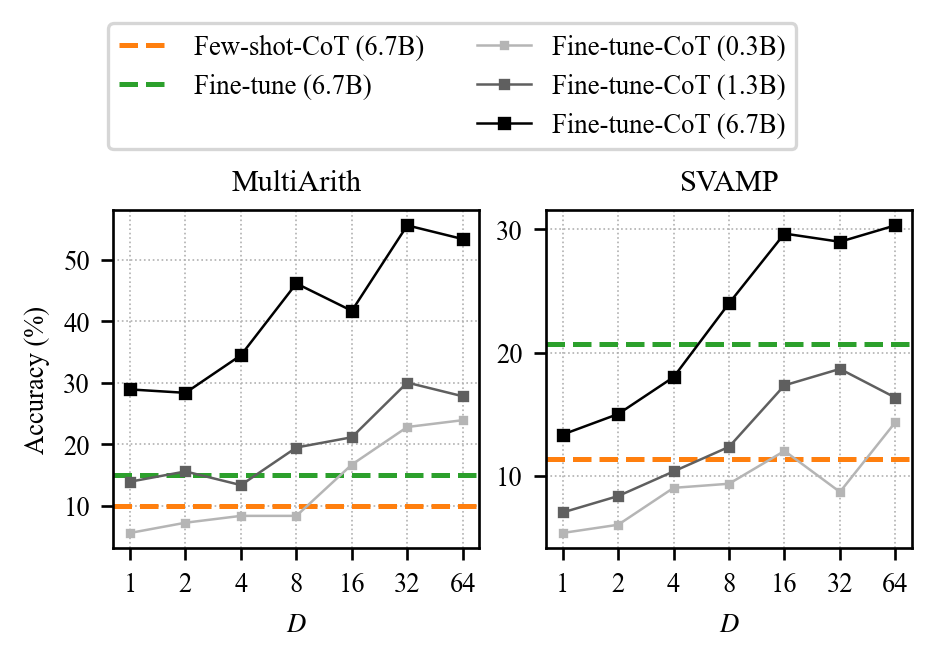

In [32]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

models = oai_students
top_model = models[-1]
n_models = len(models)

datasets = ["multiarith", "svamp"]

fig = mpl.figure.Figure((4, 2.25))
axes = fig.subplots(1, 2).flatten()

for ax, dataset in zip(axes, datasets):
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", top_model, fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", top_model, fmt=False)
    ft = get_accuracy(dataset, "ft", top_model, fmt=False)
    ft_cot_acc__model_aug = dict()
    for model in models:
        ft_cot_acc__model_aug[model] = dict()
    for aug in [1, 2, 4, 8, 16, 32, 64]:
        for model in models:
            acc = get_accuracy(dataset, "ft_cot", model, aug=aug, fmt=False)
            ft_cot_acc__model_aug[model][str(aug)] = acc
        
    # Plot baselines
    ax.axhline(fs_cot, ls="--", c="tab:orange", label=f"Few-shot-CoT ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="tab:green", label=f"Fine-tune ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="white", label=" ", alpha=0)
    
    # Plot diverse reasoniing
    # Line plots
    colors = mpl.cm.Set2(np.arange(6))
    colors = ["black"] * n_models
    colors = mpl.cm.Greys(0.4 + np.arange(n_models) / (n_models - 1) * 0.6)
    for i, (model, accs) in enumerate(ft_cot_acc__model_aug.items()):
        pd.Series(accs).plot(ax=ax, label=f"Fine-tune-CoT ({MODEL_PARAM_NAMES[model]})", color=colors[i], marker="s", markersize=(2 + i / 2), lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64], fontsize=8)
    ax.set_xlabel("$D$", fontsize=8)
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5)

axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.14), loc="lower left")
fig.savefig("figures/diverse_reasoning.pdf", bbox_inches="tight", pad_inches=0)
fig

### fig:diverse_reasoning_*

Appendix

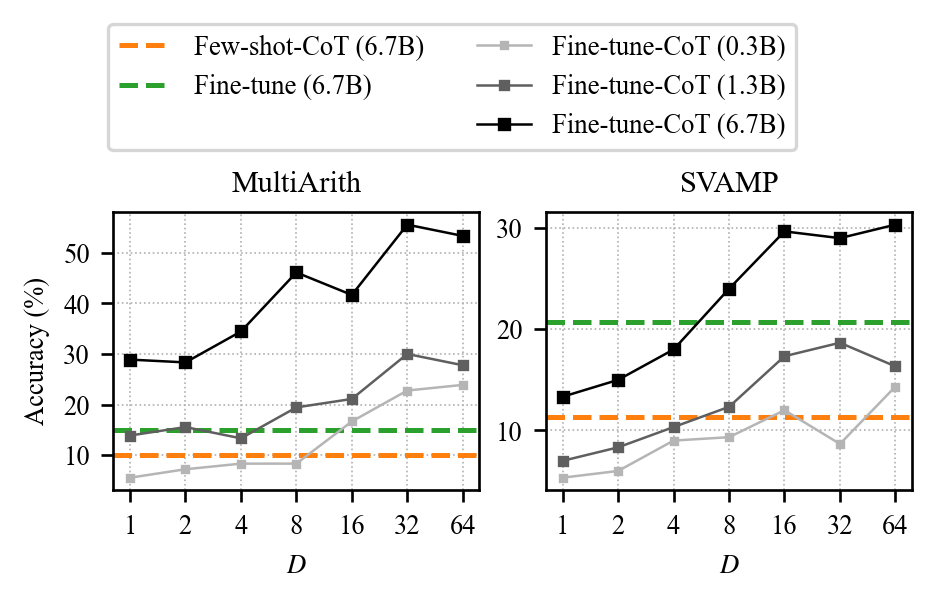

In [33]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

models = oai_students
top_model = models[-1]
n_models = len(models)

datasets = ["multiarith", "svamp"]

fig = mpl.figure.Figure((4, 2))
axes = fig.subplots(1, 2).flatten()

for ax, dataset in zip(axes, datasets):
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", top_model, fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", top_model, fmt=False)
    ft = get_accuracy(dataset, "ft", top_model, fmt=False)
    ft_cot_acc__model_aug = dict()
    for model in models:
        ft_cot_acc__model_aug[model] = dict()
    for aug in [1, 2, 4, 8, 16, 32, 64]:
        for model in models:
            acc = get_accuracy(dataset, "ft_cot", model, aug=aug, fmt=False)
            ft_cot_acc__model_aug[model][str(aug)] = acc
        
    # Plot baselines
    ax.axhline(fs_cot, ls="--", c="tab:orange", label=f"Few-shot-CoT ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="tab:green", label=f"Fine-tune ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="white", label=" ", alpha=0)
    
    # Plot diverse reasoniing
    # Line plots
    colors = mpl.cm.Set2(np.arange(6))
    colors = ["black"] * n_models
    colors = mpl.cm.Greys(0.4 + np.arange(n_models) / (n_models - 1) * 0.6)
    for i, (model, accs) in enumerate(ft_cot_acc__model_aug.items()):
        pd.Series(accs).plot(ax=ax, label=f"Fine-tune-CoT ({MODEL_PARAM_NAMES[model]})", color=colors[i], marker="s", markersize=(2 + i / 2), lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64], fontsize=8)
    ax.set_xlabel("$D$", fontsize=8)
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5)

axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.175), loc="lower left")
    
fig.savefig("figures/diverse_reasoning_gpt3.pdf", bbox_inches="tight", pad_inches=0)
fig

multiarith__zs_cot__t5_large__* not found
svamp__zs_cot__t5_large__* not found


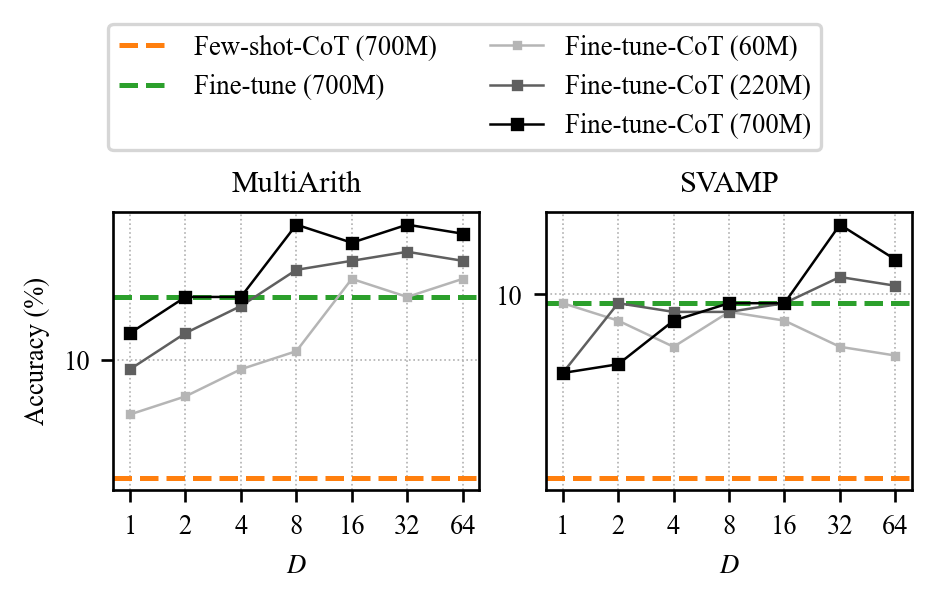

In [34]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

models = t5_students
top_model = models[-1]
n_models = len(models)

datasets = ["multiarith", "svamp"]

fig = mpl.figure.Figure((4, 2))
axes = fig.subplots(1, 2).flatten()

for ax, dataset in zip(axes, datasets):
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", top_model, fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", top_model, fmt=False)
    ft = get_accuracy(dataset, "ft", top_model, fmt=False)
    ft_cot_acc__model_aug = dict()
    for model in models:
        ft_cot_acc__model_aug[model] = dict()
    for aug in [1, 2, 4, 8, 16, 32, 64]:
        for model in models:
            acc = get_accuracy(dataset, "ft_cot", model, aug=aug, fmt=False)
            ft_cot_acc__model_aug[model][str(aug)] = acc
        
    # Plot baselines
    ax.axhline(fs_cot, ls="--", c="tab:orange", label=f"Few-shot-CoT ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="tab:green", label=f"Fine-tune ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="white", label=" ", alpha=0)
    
    # Plot diverse reasoniing
    # Line plots
    colors = mpl.cm.Set2(np.arange(6))
    colors = ["black"] * n_models
    colors = mpl.cm.Greys(0.4 + np.arange(n_models) / (n_models - 1) * 0.6)
    for i, (model, accs) in enumerate(ft_cot_acc__model_aug.items()):
        pd.Series(accs).plot(ax=ax, label=f"Fine-tune-CoT ({MODEL_PARAM_NAMES[model]})", color=colors[i], marker="s", markersize=(2 + i / 2), lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64], fontsize=8)
    ax.set_xlabel("$D$", fontsize=8)
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5)

axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.175), loc="lower left")
    
fig.savefig("figures/diverse_reasoning_t5.pdf", bbox_inches="tight", pad_inches=0)
fig

multiarith__zs_cot__flan_t5_large__* not found
svamp__zs_cot__flan_t5_large__* not found


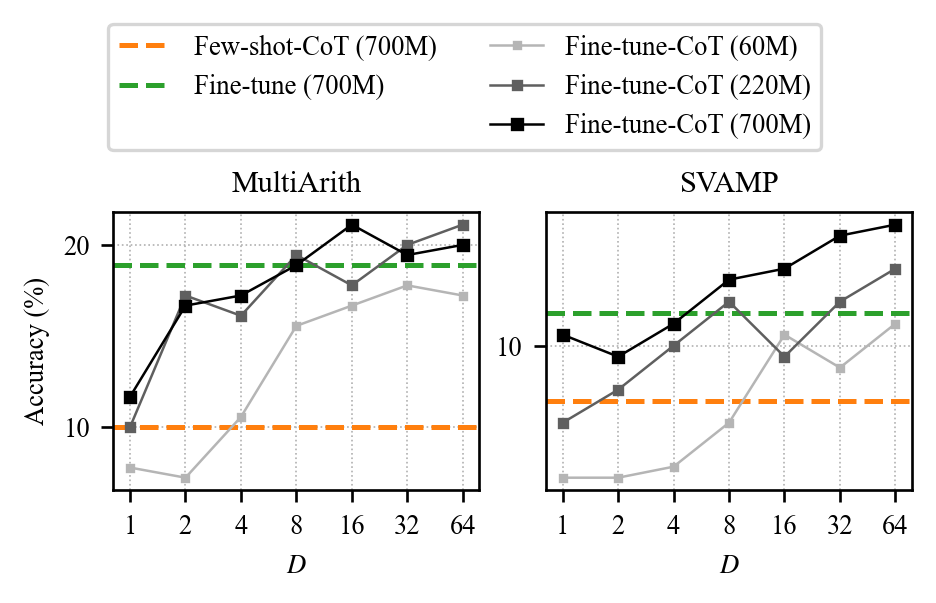

In [35]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

models = flan_t5_students
top_model = models[-1]
n_models = len(models)

datasets = ["multiarith", "svamp"]

fig = mpl.figure.Figure((4, 2))
axes = fig.subplots(1, 2).flatten()

for ax, dataset in zip(axes, datasets):
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", top_model, fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", top_model, fmt=False)
    ft = get_accuracy(dataset, "ft", top_model, fmt=False)
    ft_cot_acc__model_aug = dict()
    for model in models:
        ft_cot_acc__model_aug[model] = dict()
    for aug in [1, 2, 4, 8, 16, 32, 64]:
        for model in models:
            acc = get_accuracy(dataset, "ft_cot", model, aug=aug, fmt=False)
            ft_cot_acc__model_aug[model][str(aug)] = acc
        
    # Plot baselines
    ax.axhline(fs_cot, ls="--", c="tab:orange", label=f"Few-shot-CoT ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="tab:green", label=f"Fine-tune ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="white", label=" ", alpha=0)
    
    # Plot diverse reasoniing
    # Line plots
    colors = mpl.cm.Set2(np.arange(6))
    colors = ["black"] * n_models
    colors = mpl.cm.Greys(0.4 + np.arange(n_models) / (n_models - 1) * 0.6)
    for i, (model, accs) in enumerate(ft_cot_acc__model_aug.items()):
        pd.Series(accs).plot(ax=ax, label=f"Fine-tune-CoT ({MODEL_PARAM_NAMES[model]})", color=colors[i], marker="s", markersize=(2 + i / 2), lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64], fontsize=8)
    ax.set_xlabel("$D$", fontsize=8)
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5)

axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.175), loc="lower left")
    
fig.savefig("figures/diverse_reasoning_flan_t5.pdf", bbox_inches="tight", pad_inches=0)
fig

multiarith__zs_cot__gpt2_large__* not found
svamp__zs_cot__gpt2_large__* not found


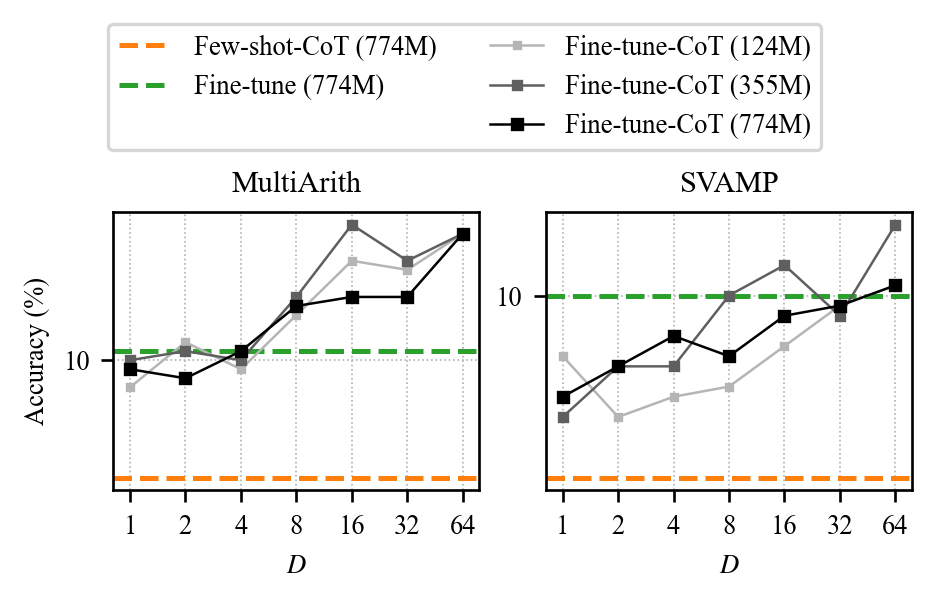

In [36]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

models = gpt2_students
top_model = models[-1]
n_models = len(models)

datasets = ["multiarith", "svamp"]

fig = mpl.figure.Figure((4, 2))
axes = fig.subplots(1, 2).flatten()

for ax, dataset in zip(axes, datasets):
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", top_model, fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", top_model, fmt=False)
    ft = get_accuracy(dataset, "ft", top_model, fmt=False)
    ft_cot_acc__model_aug = dict()
    for model in models:
        ft_cot_acc__model_aug[model] = dict()
    for aug in [1, 2, 4, 8, 16, 32, 64]:
        for model in models:
            acc = get_accuracy(dataset, "ft_cot", model, aug=aug, fmt=False)
            ft_cot_acc__model_aug[model][str(aug)] = acc
        
    # Plot baselines
    ax.axhline(fs_cot, ls="--", c="tab:orange", label=f"Few-shot-CoT ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="tab:green", label=f"Fine-tune ({MODEL_PARAM_NAMES[top_model]})")
    ax.axhline(ft, ls="--", c="white", label=" ", alpha=0)
    
    # Plot diverse reasoniing
    # Line plots
    colors = mpl.cm.Set2(np.arange(6))
    colors = ["black"] * n_models
    colors = mpl.cm.Greys(0.4 + np.arange(n_models) / (n_models - 1) * 0.6)
    for i, (model, accs) in enumerate(ft_cot_acc__model_aug.items()):
        pd.Series(accs).plot(ax=ax, label=f"Fine-tune-CoT ({MODEL_PARAM_NAMES[model]})", color=colors[i], marker="s", markersize=(2 + i / 2), lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64], fontsize=8)
    ax.set_xlabel("$D$", fontsize=8)
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5)

axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.175), loc="lower left")
    
fig.savefig("figures/diverse_reasoning_gpt2.pdf", bbox_inches="tight", pad_inches=0)
fig

# fig:dataset_size

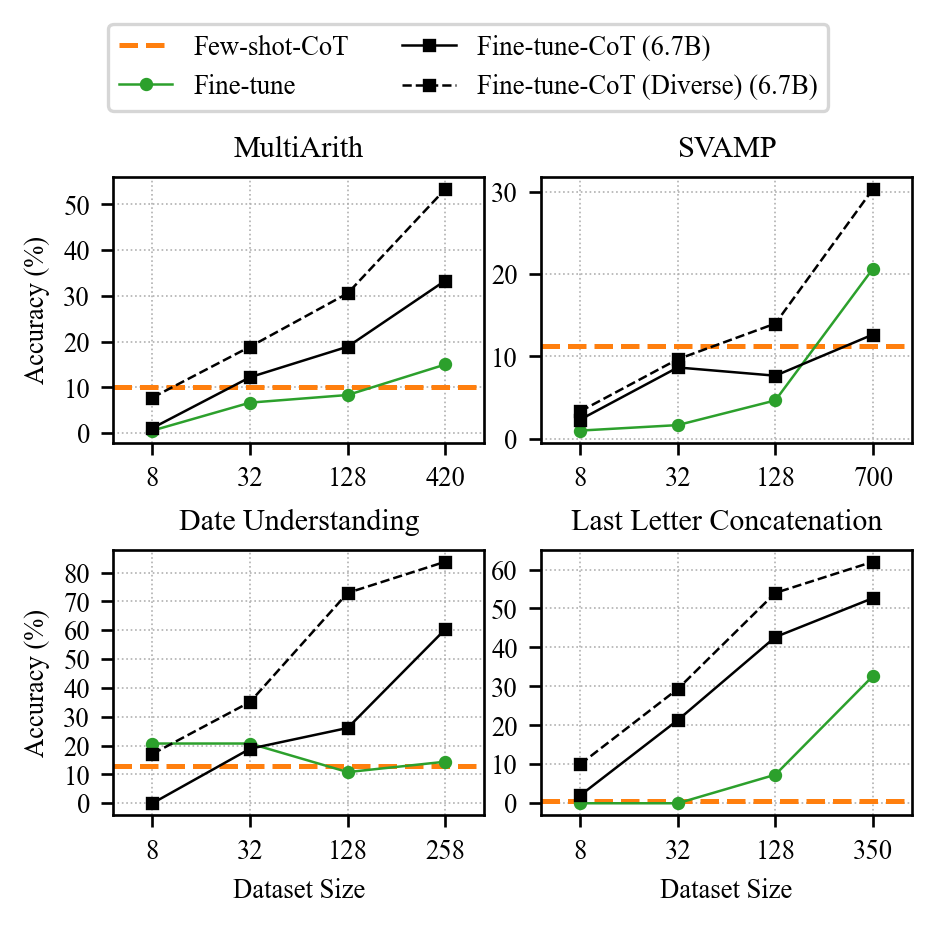

In [37]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

base_model = "curie"
datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]

fig = mpl.figure.Figure((4, 3.5))
axes = fig.subplots(2, 2).flatten()

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set1(np.arange(6))
    base_model = "curie"
    
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", base_model, fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", base_model, fmt=False)
    
    ft_accs = dict()
    ft_cot_accs = dict()
    ft_cot_diverse_accs = dict()
    for shot in [8, 32, 128, ""]:
        base_model = "curie"
        
        acc = get_accuracy(dataset, "ft", base_model, shot=shot, fmt=False)
        ft_accs[str(shot)] = acc
        
        acc = get_accuracy(dataset, "ft_cot", base_model, shot=shot, fmt=False)
        ft_cot_accs[str(shot)] = acc
        
        if dataset in ("multiarith", "svamp"):
            acc = get_accuracy(dataset, "ft_cot", base_model, aug=64, shot=shot, fmt=False)
        else:
            acc = get_accuracy(dataset, "ft_cot", base_model, aug=8, shot=shot, fmt=False)
        ft_cot_diverse_accs[str(shot)] = acc
            

    # Plot baselines
#     ax.axhline(zs_cot, ls="-", c="gray", label="Zero-shot-CoT")
#     ax.axhline(fs_cot, ls="-", c="black", label="Few-shot-CoT")
#     ax.axhline(ft, ls="-", c="red", label="Fine-tune")
#     ax.axhline(zs_cot, ls="--", c="tab:red", label="Zero-shot-CoT")
    ax.axhline(fs_cot, ls="--", c="tab:orange", label="Few-shot-CoT")
    
    # Plot ft and ft_cot
    pd.Series(ft_accs).plot(ax=ax, label="Fine-tune", color="tab:green",  marker=".", lw=0.75)
    pd.Series(ft_cot_accs).plot(ax=ax, label="Fine-tune-CoT (6.7B)", color="black", marker="s", markersize=3, lw=0.75)
    pd.Series(ft_cot_diverse_accs).plot(ax=ax, label="Fine-tune-CoT (Diverse) (6.7B)", color="black", linestyle="--", marker="s", markersize=3, lw=0.75)
#     pd.Series(ft_cot_accs2).plot(ax=ax, label="Fine-tune-CoT (1.3B)", color=colors[1], marker="s", markersize=3, lw=0.75)
#     pd.Series(ft_cot_accs3).plot(ax=ax, label="Fine-tune-CoT (0.3B)", color=colors[0], marker="s", markersize=3, lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    
    train, test = load_train_test_split(dataset)
    ax.set_title(dataset_name, fontsize=9)
    if i < 2:
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(["8", "32", "128", str(len(train))], fontsize=8)
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(["8", "32", "128", str(len(train))], fontsize=8)
        ax.set_xlabel("Dataset Size", fontsize=8)
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
    ax.set_xlim([-0.4, 3.4])
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.2, h_pad=0.5)
axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")

fig.savefig("figures/dataset_size.pdf", bbox_inches="tight", pad_inches=0)
fig

### fig:teacher_performance

last_letter_concatenation__ft_cot__curie__* not found
last_letter_concatenation__ft_cot__babbage__* not found
last_letter_concatenation__ft_cot__ada__* not found


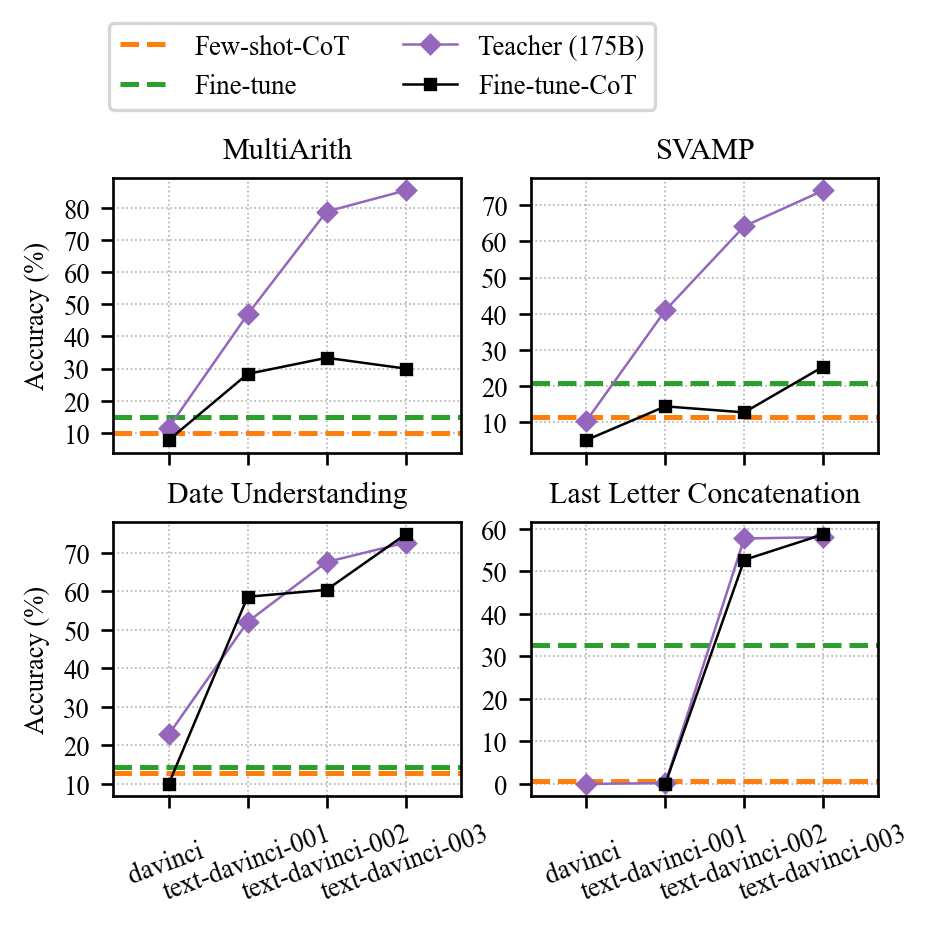

In [38]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

base_model = "curie"
datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]
teachers = ["davinci", "text-davinci-001", "text-davinci-002", "text-davinci-003"]

fig = mpl.figure.Figure((4, 3.5))
axes = fig.subplots(2, 2).flatten()

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set1(np.arange(6))
    
    # Compile data
    zs_cot = get_accuracy(dataset, "zs_cot", base_model, "", "", fmt=False)
    fs_cot = get_accuracy(dataset, "fs_cot", base_model, "", "", fmt=False)
    ft = get_accuracy(dataset, "ft", base_model, "", "", fmt=False)
    
    teacher_accs = dict()
    ft_cot_acc_curie = dict()
    ft_cot_acc_babbage = dict()
    ft_cot_acc_ada = dict()
    for teacher in teachers:
        acc = get_accuracy(dataset, "zs_cot", teacher, "", "", fmt=False)
        teacher_accs[teacher] = acc
        
        if teacher == "text-davinci-002":
            teacher = ""
        acc = get_accuracy(dataset, "ft_cot", "curie", fmt=False, teacher=teacher)
        ft_cot_acc_curie[teacher] = acc
        acc = get_accuracy(dataset, "ft_cot", "babbage", fmt=False, teacher=teacher)
        ft_cot_acc_babbage[teacher] = acc
        acc = get_accuracy(dataset, "ft_cot", "ada", fmt=False, teacher=teacher)
        ft_cot_acc_ada[teacher] = acc
    
    # Plot baselines
#     ax.axhline(zs_cot, ls="--", c="tab:red", label="Zero-shot-CoT")
    ax.axhline(fs_cot, ls="--", c="tab:orange", label="Few-shot-CoT")
    ax.axhline(ft, ls="--", c="tab:green", label="Fine-tune")
#     ax.axhline(fs_cot, ls="--", c="tab:orange", label="Few-shot-CoT (6.7B)")
#     ax.axhline(ft, ls="--", c="tab:green", label="Fine-tune (6.7B)")
    
    # Plot ft and ft_cot
    pd.Series(teacher_accs).plot(ax=ax, label="Teacher (175B)", color="tab:purple", marker="D", markersize=4, lw=0.75)
    
    
    colors = mpl.cm.Greys(0.5 + np.arange(3) / 2 * 0.5)
#     pd.Series(ft_cot_acc_curie).plot(ax=ax, label="Fine-tune-CoT (Diverse)", color=colors[3], marker=".", lw=0.5)
#     pd.Series(ft_cot_acc_ada).plot(ax=ax, label="Fine-tune-CoT (0.3B)", color=colors[0], marker="s", markersize=2, lw=0.75)
#     pd.Series(ft_cot_acc_babbage).plot(ax=ax, label="Fine-tune-CoT (1.3B)", color=colors[1], marker="s", markersize=2.5, lw=0.75)
    pd.Series(ft_cot_acc_curie).plot(ax=ax, label="Fine-tune-CoT", color=colors[2], marker="s", markersize=3, lw=0.75)
    
    dataset_name = DATASET_NAMES[dataset]
    ax.set_title(dataset_name, fontsize=9)
    if i < 2:
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels([])
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticks(np.arange(4))
        teacher_labels = ["davinci".center(22)] + teachers[1:]
        ax.set_xticklabels(teacher_labels, fontsize=8, rotation=20)
    ax.set_xlim([-0.7, 3.7])
    
    loc = plticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=-0.4, h_pad=0.5)
axes[0].legend(title=None, ncol=2, prop={"size": 8},
               title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")

fig.savefig("figures/teacher_performance.pdf", bbox_inches="tight", pad_inches=0)
fig

### fig:student_size

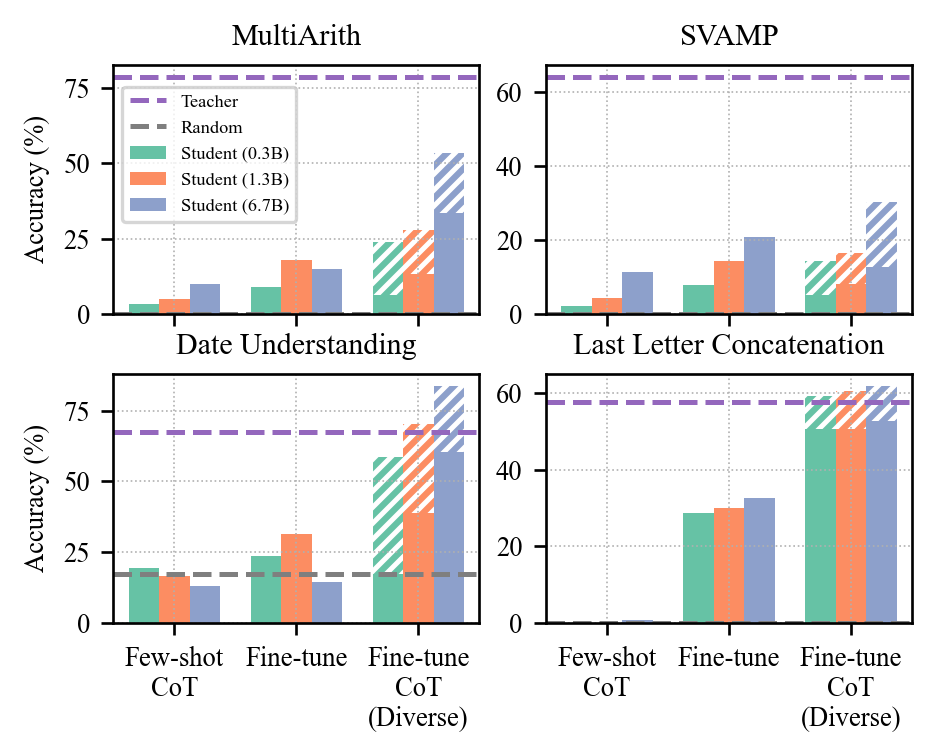

In [39]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]
models = oai_students
n_models = len(models)

fig = mpl.figure.Figure((4, 3.25))
axes = fig.subplots(2, 2).flatten()

for index, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set2(np.arange(6))
    ax.set_prop_cycle(cycler('color', colors))
    
    # Compile numbers
    methods = ["fs_cot", "ft", "ft_cot"]
    teacher_acc = get_accuracy(dataset, "zs_cot", "text-davinci-002", fmt=False)
    random_acc = random_performances[dataset] or 0
    accs_by_student = defaultdict(list)  # student: accs_by_method
    for student in models:
        for method in methods:
            acc = get_accuracy(dataset, method, student, fmt=False)
            accs_by_student[student].append(acc)
    
    ft_cot_by_student = dict()
    ft_cot_diverse_by_student = dict()
    for student in models:
        for method in methods:
            ft_cot_by_student[student] = get_accuracy(dataset, "ft_cot", student, fmt=False)
            if dataset in ["multiarith", "svamp"]:
                acc = get_accuracy(dataset, "ft_cot", student, aug=64, fmt=False)
            else:
                acc = get_accuracy(dataset, "ft_cot", student, aug=8, fmt=False)
            ft_cot_diverse_by_student[student] = acc
                
    # Plot baselines
    ax.axhline(teacher_acc, ls="--", c="tab:purple", label="Teacher")
    ax.axhline(random_acc * 100, ls="--", c="tab:gray", label="Random")
    
    # Plot methods
    method_locations = np.arange(0, (n_models + 1) * 3, n_models + 1)
    student_offsets = np.arange(0, n_models)
    student_offsets = student_offsets - np.mean(student_offsets)
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        student_name = f"Student ({MODEL_PARAM_NAMES[student]})"
        ax.bar(method_locations + offset, accs_by_student[student], label=student_name, width=1)
    
    # Plot ft_cot diverse
    method_location = method_locations[-1]
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        ft_cot = ft_cot_by_student[student]
        ft_cot_diverse = ft_cot_diverse_by_student[student]
        delta = ft_cot_diverse - ft_cot
        mpl.rcParams['hatch.linewidth'] = 1.5
        ax.bar(method_location + offset, delta, bottom=ft_cot, label=None, width=1, fill=True, color=colors[i], edgecolor="white", linewidth=0, hatch="/////")
    
    
    dataset_name = DATASET_NAMES[dataset]
    ax.set_xticks(method_locations)
    method_names = ["Few-shot\nCoT", "Fine-tune", "Fine-tune\nCoT\n(Diverse)"]
    ax.set_title(dataset_name, fontsize=9)
    if index < 2:
        ax.set_xticklabels([], fontsize=8)
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticklabels(method_names, fontsize=8)
    ax.set_xlim([method_locations[0] - (n_models + 1) / 2, method_locations[-1] + (n_models + 1) / 2])
    
#     loc = plticker.MultipleLocator(base=10)
#     ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5, h_pad=0.1)
# axes[0].legend(title=None, ncol=3, prop={"size": 8},
#                title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")
axes[0].legend(prop={"size": 5.5}, title_fontproperties={"size": 6},
               loc="upper right", bbox_to_anchor=(0.525, 0.95))

fig.savefig("figures/student_size.pdf", bbox_inches="tight", pad_inches=0)
fig

### fig:student_size_*

Appendix

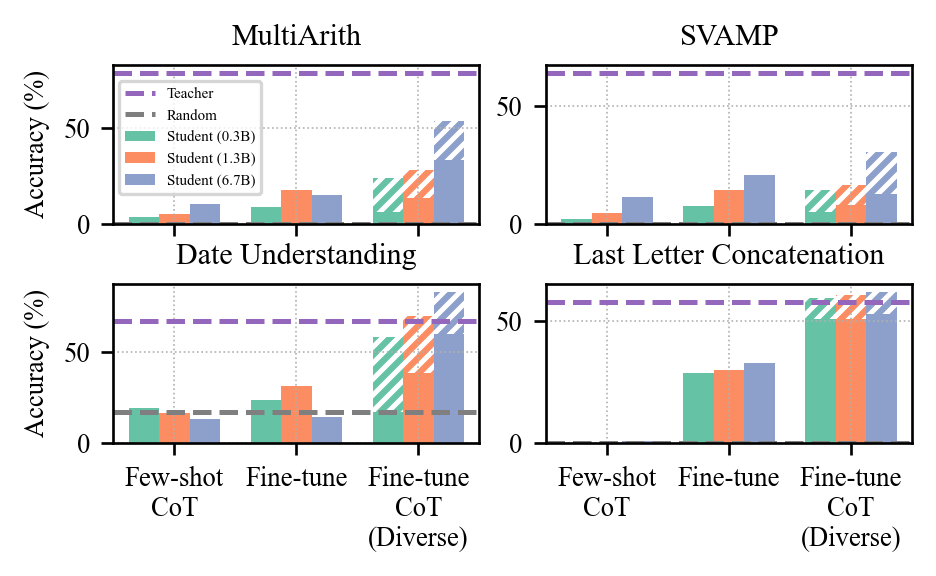

In [40]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]
models = oai_students
n_models = len(models)

fig = mpl.figure.Figure((4, 2.5))
axes = fig.subplots(2, 2).flatten()

for index, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set2(np.arange(6))
    ax.set_prop_cycle(cycler('color', colors))
    
    # Compile numbers
    methods = ["fs_cot", "ft", "ft_cot"]
    teacher_acc = get_accuracy(dataset, "zs_cot", "text-davinci-002", fmt=False)
    random_acc = random_performances[dataset] or 0
    accs_by_student = defaultdict(list)  # student: accs_by_method
    for student in models:
        for method in methods:
            acc = get_accuracy(dataset, method, student, fmt=False)
            accs_by_student[student].append(acc)
    
    ft_cot_by_student = dict()
    ft_cot_diverse_by_student = dict()
    for student in models:
        for method in methods:
            ft_cot_by_student[student] = get_accuracy(dataset, "ft_cot", student, fmt=False)
            if dataset in ["multiarith", "svamp"]:
                acc = get_accuracy(dataset, "ft_cot", student, aug=64, fmt=False)
            else:
                acc = get_accuracy(dataset, "ft_cot", student, aug=8, fmt=False)
            ft_cot_diverse_by_student[student] = acc
                
    # Plot baselines
    ax.axhline(teacher_acc, ls="--", c="tab:purple", label="Teacher")
    ax.axhline(random_acc * 100, ls="--", c="tab:gray", label="Random")
    
    # Plot methods
    method_locations = np.arange(0, (n_models + 1) * 3, n_models + 1)
    student_offsets = np.arange(0, n_models)
    student_offsets = student_offsets - np.mean(student_offsets)
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        student_name = f"Student ({MODEL_PARAM_NAMES[student]})"
        ax.bar(method_locations + offset, accs_by_student[student], label=student_name, width=1)
    
    # Plot ft_cot diverse
    method_location = method_locations[-1]
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        ft_cot = ft_cot_by_student[student]
        ft_cot_diverse = ft_cot_diverse_by_student[student]
        delta = ft_cot_diverse - ft_cot
        mpl.rcParams['hatch.linewidth'] = 1.5
        ax.bar(method_location + offset, delta, bottom=ft_cot, label=None, width=1, fill=True, color=colors[i], edgecolor="white", linewidth=0, hatch="/////")
    
    
    dataset_name = DATASET_NAMES[dataset]
    ax.set_xticks(method_locations)
    method_names = ["Few-shot\nCoT", "Fine-tune", "Fine-tune\nCoT\n(Diverse)"]
    ax.set_title(dataset_name, fontsize=9)
    if index < 2:
        ax.set_xticklabels([], fontsize=8)
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticklabels(method_names, fontsize=8)
    ax.set_xlim([method_locations[0] - (n_models + 1) / 2, method_locations[-1] + (n_models + 1) / 2])
    
#     loc = plticker.MultipleLocator(base=10)
#     ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5, h_pad=0.1)
# axes[0].legend(title=None, ncol=3, prop={"size": 8},
#                title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")
axes[0].legend(prop={"size": 4.5}, title_fontproperties={"size": 6},
               loc="upper right", bbox_to_anchor=(0.425, 0.945))

fig.savefig("figures/student_size_gpt3.pdf", bbox_inches="tight", pad_inches=0)
fig

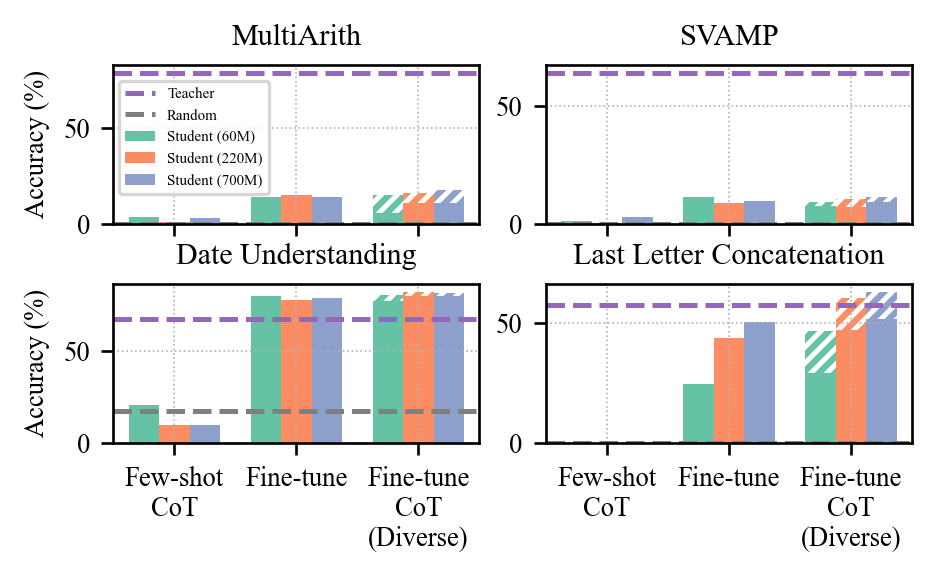

In [41]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]
models = t5_students
n_models = len(models)

fig = mpl.figure.Figure((4, 2.5))
axes = fig.subplots(2, 2).flatten()

for index, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set2(np.arange(6))
    ax.set_prop_cycle(cycler('color', colors))
    
    # Compile numbers
    methods = ["fs_cot", "ft", "ft_cot"]
    teacher_acc = get_accuracy(dataset, "zs_cot", "text-davinci-002", fmt=False)
    random_acc = random_performances[dataset] or 0
    accs_by_student = defaultdict(list)  # student: accs_by_method
    for student in models:
        for method in methods:
            acc = get_accuracy(dataset, method, student, fmt=False)
            accs_by_student[student].append(acc)
    
    ft_cot_by_student = dict()
    ft_cot_diverse_by_student = dict()
    for student in models:
        for method in methods:
            ft_cot_by_student[student] = get_accuracy(dataset, "ft_cot", student, fmt=False)
            if dataset in ["multiarith", "svamp"]:
                acc = get_accuracy(dataset, "ft_cot", student, aug=64, fmt=False)
            else:
                acc = get_accuracy(dataset, "ft_cot", student, aug=8, fmt=False)
            ft_cot_diverse_by_student[student] = acc
                
    # Plot baselines
    ax.axhline(teacher_acc, ls="--", c="tab:purple", label="Teacher")
    ax.axhline(random_acc * 100, ls="--", c="tab:gray", label="Random")
    
    # Plot methods
    method_locations = np.arange(0, (n_models + 1) * 3, n_models + 1)
    student_offsets = np.arange(0, n_models)
    student_offsets = student_offsets - np.mean(student_offsets)
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        student_name = f"Student ({MODEL_PARAM_NAMES[student]})"
        ax.bar(method_locations + offset, accs_by_student[student], label=student_name, width=1)
    
    # Plot ft_cot diverse
    method_location = method_locations[-1]
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        ft_cot = ft_cot_by_student[student]
        ft_cot_diverse = ft_cot_diverse_by_student[student]
        delta = ft_cot_diverse - ft_cot
        mpl.rcParams['hatch.linewidth'] = 1.5
        ax.bar(method_location + offset, delta, bottom=ft_cot, label=None, width=1, fill=True, color=colors[i], edgecolor="white", linewidth=0, hatch="/////")
    
    
    dataset_name = DATASET_NAMES[dataset]
    ax.set_xticks(method_locations)
    method_names = ["Few-shot\nCoT", "Fine-tune", "Fine-tune\nCoT\n(Diverse)"]
    ax.set_title(dataset_name, fontsize=9)
    if index < 2:
        ax.set_xticklabels([], fontsize=8)
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticklabels(method_names, fontsize=8)
    ax.set_xlim([method_locations[0] - (n_models + 1) / 2, method_locations[-1] + (n_models + 1) / 2])
    
#     loc = plticker.MultipleLocator(base=10)
#     ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5, h_pad=0.1)
# axes[0].legend(title=None, ncol=3, prop={"size": 8},
#                title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")
axes[0].legend(prop={"size": 4.5}, title_fontproperties={"size": 6},
               loc="upper right", bbox_to_anchor=(0.445, 0.945))

fig.savefig("figures/student_size_t5.pdf", bbox_inches="tight", pad_inches=0)
fig

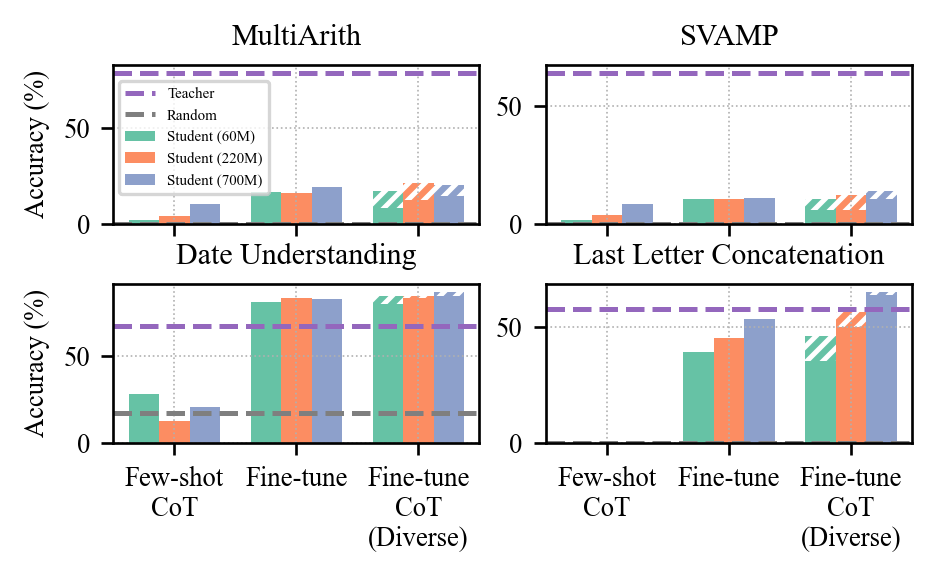

In [42]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]
models = flan_t5_students
n_models = len(models)

fig = mpl.figure.Figure((4, 2.5))
axes = fig.subplots(2, 2).flatten()

for index, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set2(np.arange(6))
    ax.set_prop_cycle(cycler('color', colors))
    
    # Compile numbers
    methods = ["fs_cot", "ft", "ft_cot"]
    teacher_acc = get_accuracy(dataset, "zs_cot", "text-davinci-002", fmt=False)
    random_acc = random_performances[dataset] or 0
    accs_by_student = defaultdict(list)  # student: accs_by_method
    for student in models:
        for method in methods:
            acc = get_accuracy(dataset, method, student, fmt=False)
            accs_by_student[student].append(acc)
    
    ft_cot_by_student = dict()
    ft_cot_diverse_by_student = dict()
    for student in models:
        for method in methods:
            ft_cot_by_student[student] = get_accuracy(dataset, "ft_cot", student, fmt=False)
            if dataset in ["multiarith", "svamp"]:
                acc = get_accuracy(dataset, "ft_cot", student, aug=64, fmt=False)
            else:
                acc = get_accuracy(dataset, "ft_cot", student, aug=8, fmt=False)
            ft_cot_diverse_by_student[student] = acc
                
    # Plot baselines
    ax.axhline(teacher_acc, ls="--", c="tab:purple", label="Teacher")
    ax.axhline(random_acc * 100, ls="--", c="tab:gray", label="Random")
    
    # Plot methods
    method_locations = np.arange(0, (n_models + 1) * 3, n_models + 1)
    student_offsets = np.arange(0, n_models)
    student_offsets = student_offsets - np.mean(student_offsets)
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        student_name = f"Student ({MODEL_PARAM_NAMES[student]})"
        ax.bar(method_locations + offset, accs_by_student[student], label=student_name, width=1)
    
    # Plot ft_cot diverse
    method_location = method_locations[-1]
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        ft_cot = ft_cot_by_student[student]
        ft_cot_diverse = ft_cot_diverse_by_student[student]
        delta = ft_cot_diverse - ft_cot
        mpl.rcParams['hatch.linewidth'] = 1.5
        ax.bar(method_location + offset, delta, bottom=ft_cot, label=None, width=1, fill=True, color=colors[i], edgecolor="white", linewidth=0, hatch="/////")
    
    
    dataset_name = DATASET_NAMES[dataset]
    ax.set_xticks(method_locations)
    method_names = ["Few-shot\nCoT", "Fine-tune", "Fine-tune\nCoT\n(Diverse)"]
    ax.set_title(dataset_name, fontsize=9)
    if index < 2:
        ax.set_xticklabels([], fontsize=8)
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticklabels(method_names, fontsize=8)
    ax.set_xlim([method_locations[0] - (n_models + 1) / 2, method_locations[-1] + (n_models + 1) / 2])
    
#     loc = plticker.MultipleLocator(base=10)
#     ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5, h_pad=0.1)
# axes[0].legend(title=None, ncol=3, prop={"size": 8},
#                title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")
axes[0].legend(prop={"size": 4.5}, title_fontproperties={"size": 6},
               loc="upper right", bbox_to_anchor=(0.445, 0.945))

fig.savefig("figures/student_size_flan_t5.pdf", bbox_inches="tight", pad_inches=0)
fig

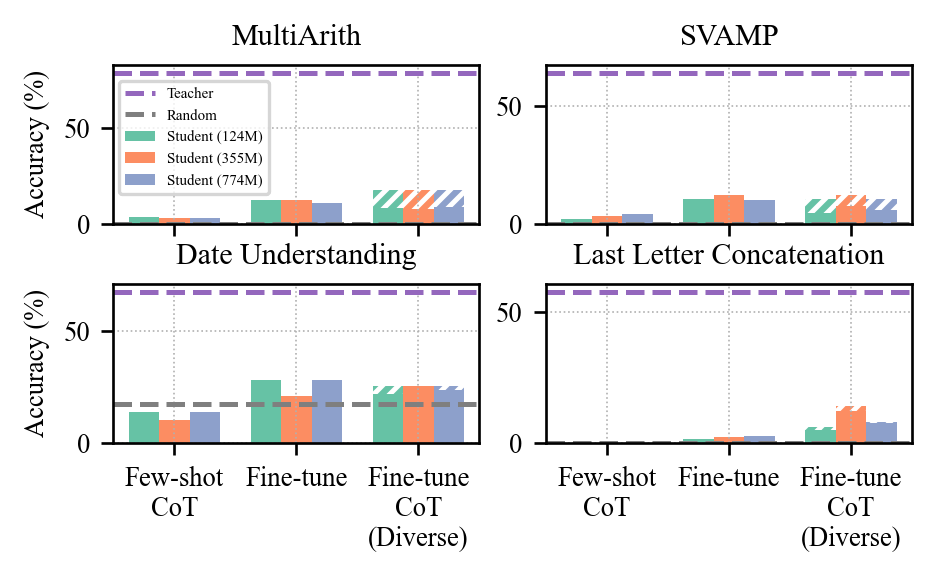

In [43]:
import matplotlib.ticker as plticker
mpl.rcParams['mathtext.fontset'] = 'stix'

datasets = ["multiarith", "svamp", "date_understanding", "last_letter_concatenation"]
models = gpt2_students
n_models = len(models)

fig = mpl.figure.Figure((4, 2.5))
axes = fig.subplots(2, 2).flatten()

for index, (ax, dataset) in enumerate(zip(axes, datasets)):
    colors = mpl.cm.Set2(np.arange(6))
    ax.set_prop_cycle(cycler('color', colors))
    
    # Compile numbers
    methods = ["fs_cot", "ft", "ft_cot"]
    teacher_acc = get_accuracy(dataset, "zs_cot", "text-davinci-002", fmt=False)
    random_acc = random_performances[dataset] or 0
    accs_by_student = defaultdict(list)  # student: accs_by_method
    for student in models:
        for method in methods:
            acc = get_accuracy(dataset, method, student, fmt=False)
            accs_by_student[student].append(acc)
    
    ft_cot_by_student = dict()
    ft_cot_diverse_by_student = dict()
    for student in models:
        for method in methods:
            ft_cot_by_student[student] = get_accuracy(dataset, "ft_cot", student, fmt=False)
            if dataset in ["multiarith", "svamp"]:
                acc = get_accuracy(dataset, "ft_cot", student, aug=64, fmt=False)
            else:
                acc = get_accuracy(dataset, "ft_cot", student, aug=8, fmt=False)
            ft_cot_diverse_by_student[student] = acc
                
    # Plot baselines
    ax.axhline(teacher_acc, ls="--", c="tab:purple", label="Teacher")
    ax.axhline(random_acc * 100, ls="--", c="tab:gray", label="Random")
    
    # Plot methods
    method_locations = np.arange(0, (n_models + 1) * 3, n_models + 1)
    student_offsets = np.arange(0, n_models)
    student_offsets = student_offsets - np.mean(student_offsets)
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        student_name = f"Student ({MODEL_PARAM_NAMES[student]})"
        ax.bar(method_locations + offset, accs_by_student[student], label=student_name, width=1)
    
    # Plot ft_cot diverse
    method_location = method_locations[-1]
    for i, (student, offset) in enumerate(zip(models, student_offsets)):
        ft_cot = ft_cot_by_student[student]
        ft_cot_diverse = ft_cot_diverse_by_student[student]
        delta = ft_cot_diverse - ft_cot
        mpl.rcParams['hatch.linewidth'] = 1.5
        ax.bar(method_location + offset, delta, bottom=ft_cot, label=None, width=1, fill=True, color=colors[i], edgecolor="white", linewidth=0, hatch="/////")
    
    
    dataset_name = DATASET_NAMES[dataset]
    ax.set_xticks(method_locations)
    method_names = ["Few-shot\nCoT", "Fine-tune", "Fine-tune\nCoT\n(Diverse)"]
    ax.set_title(dataset_name, fontsize=9)
    if index < 2:
        ax.set_xticklabels([], fontsize=8)
#         ax.tick_params(bottom=False)
    else:
        ax.set_xticklabels(method_names, fontsize=8)
    ax.set_xlim([method_locations[0] - (n_models + 1) / 2, method_locations[-1] + (n_models + 1) / 2])
    
#     loc = plticker.MultipleLocator(base=10)
#     ax.yaxis.set_major_locator(loc)
    ax.tick_params("y", labelsize=8)
    ax.grid(axis="both", ls=":", lw=0.5)
    
axes[0].set_ylabel("Accuracy (%)", fontsize=8)
axes[2].set_ylabel("Accuracy (%)", fontsize=8)

fig.tight_layout(w_pad=0.5, h_pad=0.1)
# axes[0].legend(title=None, ncol=3, prop={"size": 8},
#                title_fontproperties={"size": 8}, bbox_to_anchor=(-0.05, 1.2), loc="lower left")
axes[0].legend(prop={"size": 4.5}, title_fontproperties={"size": 6},
               loc="upper right", bbox_to_anchor=(0.445, 0.945))

fig.savefig("figures/student_size_gpt2.pdf", bbox_inches="tight", pad_inches=0)
fig

# table:template_split

TODO: update code

In [44]:
data = defaultdict(dict)

for dataset in ["multiarith", "date_understanding"]:
    dataset_name = DATASET_NAMES[dataset]
    for base_model, base_model_name in zip("ada,babbage,curie".split(","), "0.3B,1.3B,6.7B".split(",")):
        for method, method_name in zip(["ft_cot", "ft_cot_template"], ["Sample-wise", "Template-wise"]):
            try:
                s = summary
                s = s[s.dataset == dataset]
                s = s[s.method == method]
                s = s[s.base_model == base_model]
                s = s[s.aug == ""]
                s = s[s.shot == ""]
                accuracy = s.accuracy.item() * 100
            except (KeyError, ValueError):
                accuracy = np.nan
            data[dataset_name][(base_model_name, method_name)] = accuracy
    data[dataset_name][("Random", "")] = better_random_performance[dataset] * 100
        
data = pd.DataFrame(data).applymap("{:.2f}".format)
data.index.names = ("Params", "Split")
print(data.style.to_latex(multicol_align="c", multirow_align="c", hrules=True))
data

AttributeError: 'DataFrame' object has no attribute 'dataset'

# tab:sample_filtering

TODO: update code

In [ ]:
data = defaultdict(dict)

dataset = "date_understanding"
dataset_name = DATASET_NAMES[dataset]

method_method_name_filter_method_samples = [
    ("zs_cot", "Zero-shot-CoT", "" , 0),
    ("ft_cot_all", "Fine-tune-CoT", "None" , 258),
    ("ft_cot_short_long", "Fine-tune-CoT", "Answer" , 170),
    ("ft_cot_good", "Fine-tune-CoT", "Golden" , 123),
    ("ft_cot_good_baseline", "Fine-tune-CoT", "Answer$\\textsuperscript{†}$" , 123),
#     ("ft_cot_all", "ft_cot", "" , 170),
]
for method, method_name, filter_method, samples in method_method_name_filter_method_samples:
    data[method]["Method"] = method_name
    data[method]["Filter"] = filter_method
    data[method]["Samples"] = samples
    for base_model, base_model_name in zip("ada,babbage,curie".split(","), "0.3B,1.3B,6.7B".split(",")):
        if "ft_cot" in method:
            teacher = "text-davinci-002"
        else:
            teacher = ""
        accuracy = get_accuracy(dataset, method, base_model, teacher=teacher)
        data[method][base_model_name] = accuracy
        
method_method_name_filter_method_samples = [
    ("ft_cot_all", "Fine-tune-CoT", "None", 258),
    ("ft_cot_short_long", "Fine-tune-CoT", "Answer", 170),
#     ("ft_cot_all", "ft_cot", "" , 170),
]
for aug in [1, 2, 4, 8]:
    for method, method_name, filter_method, samples in method_method_name_filter_method_samples:
        method_key = method +  "_{}aug".format(aug)
        data[method_key]["Method"] = method_name
        data[method_key]["Filter"] = filter_method
        data[method_key]["Samples"] = samples
        for base_model, base_model_name in zip("ada,babbage,curie".split(","), "0.3B,1.3B,6.7B".split(",")):
            if "ft_cot" in method:
                teacher = "text-davinci-002"
            else:
                teacher = ""
            accuracy = get_accuracy(dataset, method, base_model, shot="", aug=aug, teacher=teacher)
            data[method_key][base_model_name] = accuracy
        
data["random"]["Method"] = "Random"
data["random"]["Filter"] = ""
data["random"]["Samples"] = ""
data["random"]["0.3B"] = float(better_random_performance[dataset] * 100)
data["random"]["1.3B"] = ""
data["random"]["6.7B"] = ""
        
data = pd.DataFrame(data).T.applymap(lambda v: "{:.2f}".format(v) if type(v) == float else v)
print(data.style.hide(axis="index").to_latex(multicol_align="c", multirow_align="c", hrules=True))
data

# tab:inference_length

In [ ]:
def format_completion(accuracy, completion):
    if completion < 90:
        return "\\textbf{{\\small{{({:.2f})}}}}".format(completion)
    else:
        return "\\small{{({:.2f})}}".format(completion)
    
data = defaultdict(dict)

for dataset in datasets:
    dataset_name = DATASET_NAMES[dataset]
    
    # teacher
    base_model, base_model_name = "idavinci", "teacher"
    for method, method_name in zip(["zs_cot", "zs_cot_long"], ["128", "2048"]):
        try:
            s = summary
            s = s[s.dataset == dataset]
            s = s[s.method == method]
            s = s[s.base_model == base_model]
            s = s[s.aug == ""]
            s = s[s.shot == ""]
            accuracy = s.accuracy.item() * 100
            completion = s.reason_complete.item() * 100
        except (KeyError, ValueError):
            accuracy = np.nan
            completion = np.nan
        data[dataset_name][(base_model_name, method_name)] = "{:.2f}".format(accuracy)
        data[dataset_name][(base_model_name, method_name + "s")] = format_completion(accuracy, completion)
    
    # students
    for base_model, base_model_name in zip("ada,babbage,curie".split(","), "0.3B,1.3B,6.7B".split(",")):
        for method, method_name in zip(["ft_cot", "ft_cot_short_long"], ["128", "1024"]):
            try:
                s = summary
                s = s[s.dataset == dataset]
                s = s[s.method == method]
                s = s[s.base_model == base_model]
                s = s[s.aug == ""]
                s = s[s.shot == ""]
                accuracy = s.accuracy.item() * 100
                completion = s.complete.item() * 100
            except (KeyError, ValueError):
                accuracy = np.nan
                completion = np.nan
            data[dataset_name][(base_model_name, method_name)] = "{:.2f}".format(accuracy)
            data[dataset_name][(base_model_name, method_name + "s")] = format_completion(accuracy, completion)
            
    data[dataset_name][("Random", "")] = "{:.2f}".format(better_random_performance[dataset] * 100)
        
data = pd.DataFrame(data)
data.index.names = ("Params", "Max Tokens")
print(data.style.to_latex(multicol_align="c", multirow_align="c", hrules=True))
data

# tab:fine_tune_length

In [ ]:
data = defaultdict(dict)

for dataset in ["gsm8k", "aqua", "commonsense_qa", "strategy_qa"]:
    dataset_name = DATASET_NAMES[dataset]
    for base_model, base_model_name in zip("ada,babbage,curie".split(","), "0.3B,1.3B,6.7B".split(",")):
        for method, method_name in zip(["ft_cot_short_long", "ft_cot_long_long"], ["128", "512"]):
            try:
                s = summary
                s = s[s.dataset == dataset]
                s = s[s.method == method]
                s = s[s.base_model == base_model]
                s = s[s.aug == ""]
                s = s[s.shot == ""]
                accuracy = s.accuracy.item() * 100
            except (KeyError, ValueError):
                accuracy = np.nan
            data[dataset_name][(base_model_name, method_name)] = accuracy
    data[dataset_name][("Random", "")] = better_random_performance[dataset] * 100
        
data = pd.DataFrame(data).applymap("{:.2f}".format)
data.index.names = ("Params", "Max Tokens")
print(data.style.to_latex(multicol_align="c", multirow_align="c", hrules=True))
data

# fig:length_distribution

In [ ]:
import seaborn as sns

In [ ]:
from data.tokens import get_token_count
def get_token_counts(completion_data, indices):
    token_counts = []
    for i in tqdm(indices):
        sample = completion_data[i][0]
        if "reasoning_completion" in sample:
            r = get_token_count(sample["reasoning_completion"])
            c = get_token_count(sample["completion"])
            token_counts.append(r + c)
        else:
            c = get_token_count(sample["completion"])
            token_counts.append(c)
    return token_counts

In [ ]:
token_counts_by_dataset_by_method = defaultdict(dict)
for dataset in ["gsm8k", "aqua", "commonsense_qa", "strategy_qa"]:
    dataset_name = DATASET_NAMES[dataset]
    for model_key, method, completion_key in [
        ("text-davinci-002", "Teacher", "zs_cot_long"),
        ("curie_zs_cot_special_{}_train".format(dataset), "Student (Short)", "finetune_cot_long"),
        ("curie_zs_cot_long_special_{}_train".format(dataset), "Student (Long)", "finetune_cot_long"),
    ]:
        completion_data = load_completion_data(completion_key, dataset, model_key)
        train, test = get_train_test_indices(dataset)
        token_counts = get_token_counts(completion_data, test)
        token_counts_by_dataset_by_method[dataset][method] = token_counts

In [ ]:
from data.tokens import get_token_count
def get_token_counts(completion_data, indices):
    token_counts = []
    for i in tqdm(indices):
        sample = samples[i][0]
        if "reasoning_completion" in sample:
            r = get_token_count(sample["reasoning_completion"])
            c = get_token_count(sample["completion"])
            if r < 2000:
                token_counts.append(r + c)
        else:
            c = get_token_count(sample["completion"])
            if c < 1024:
                token_counts.append(c)
    return token_counts

In [ ]:
mpl.figure.Figure(10, 10)

In [ ]:
fig = mpl.figure.Figure((8, 2.25))
axes = fig.subplots(1, 4).flatten()
for i, ax, (dataset, stats) in zip(range(4), axes, token_counts_by_dataset_by_method.items()):
    for j, (method, token_counts), color in zip(range(3), stats.items(), ["tab:orange", "tab:blue", "tab:green"]):
        ax.hist(token_counts, bins=range(j * 6, 512, 20), density=True, stacked=True, fill=True, alpha=0.3, histtype="step", color=color, label=method)
        ax.hist(token_counts, bins=range(j * 6, 512, 20), density=True, stacked=True, fill=False, histtype="step", edgecolor=color)
    ax.set_xticks(range(0, 513, 128))
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_xlabel("Tokens", fontsize=9)
    if i == 0:
        ax.set_ylabel("Probability", fontsize=9)
    ax.grid(ls="--", lw=0.5)
    ax.set_title(FULL_DATASET_NAMES[dataset], fontsize=9)
    if i == 3:
        ax.legend(prop={"size": 7}, title_fontproperties={"size": 7})
fig.tight_layout()
fig.savefig("figures/length_distribution.pdf", bbox_inches="tight", pad_inches=0)
fig

# Repeated Diverse Reasoning Inference

In [ ]:
summary = []

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=RuntimeWarning)
    
    template = "special"
    for base_model_key in ["ada", "babbage"]:
        dataset_key = "multiarith"
        completion_key = "finetune_cot_repeat"
        file_keys = []
        methods = []
        shots = []
        augs = []
        for shot in ["", 8, 32, 128]:
            if shot == "":
                shot_str = ""
            else:
                shot_str = "{}shot_".format(shot)
            for aug in [1, 2, 4, 8, 16, 32]:
                file_keys.append("zs_cot_special_{}_{}{}aug".format(dataset_key, shot_str, aug))
                methods.append("ft_cot_repeat")
                shots.append(shot)
                augs.append(aug)

        for file_key, method, shot, aug in zip( file_keys, methods, shots, augs):
            model_key = "{}_{}".format(base_model_key, file_key)
            completion_data = load_completion_data(completion_key, dataset_key, model_key)
            if not completion_data:
                continue
            item = dict()
            item["base_model"] = base_model_key
            item["method"] = method
            item["shot"] = shot
            item["aug"] = aug
            accs = []
            for run in [0, 1, 2, 3, 4]:
                evaluation = evaluate_completions(completion_data, dataset_key, template=template,
                                                  print_metrics=False, augmentation_indices=[run])
                metrics = get_evaluation_metrics(evaluation)
                acc = metrics["accuracy"] * 100
                accs.append(acc)
                item["acc{}".format(run)] = acc
            item["mean".format(run)] = sum(accs) / len(accs)
            item["min".format(run)] = min(accs)
            item["max".format(run)] = max(accs)
            item["std".format(run)] = pd.Series(accs).std().item()
            item["std".format(run)] = pd.Series(accs).std().item()
            summary.append(item)

summary = pd.DataFrame(summary)

In [ ]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(summary)

In [ ]:
fig = mpl.figure.Figure((8, 2.25))
axes = fig.subplots(1, 4).flatten()
s = summary
s = s[s.base_model == "ada"]
s = s.reset_index()
for i, shot in enumerate([8, 32, 128, ""]):
    x = np.arange(6)
    df = s[s.shot == shot]
    std = df["std"]
    dof = len(df)-1 
    t_crit = np.abs(t.ppf((1 - 0.95) /2, dof))
    radius = std * t_crit / np.sqrt(len(x))
    # All
#     for j in range(5):
#         axes[i].plot(x, df["acc{}".format(j)], alpha=1, c="tab:blue", linewidth=0.5)
    # Fill
#     axes[i].fill_between(x, df["mean"] - radius, df["mean"] + radius, color="tab:blue", alpha=0.3)
    # Error-bar
    axes[i].errorbar(x, df["mean"], yerr=radius, capsize=2, lw=0.5)
    
    axes[i].plot(x, df["mean"], c="tab:blue")
    axes[i].scatter(x, df["mean"], s=16)
    axes[i].set_xticks(np.arange(6))
    axes[i].set_xticklabels("1 2 4 8 16 32".split(), fontsize=8)
    axes[i].set_xlabel("Reasoning Diversity", fontsize=9)
    axes[i].set_ylabel("Accuracy (%)", fontsize=9)
    axes[i].grid(ls="--", lw=0.5)
    if shot:
        axes[i].set_title("{}-shot".format(shot), fontsize=9)
    else:
        axes[i].set_title("Full Dataset", fontsize=9)
fig.tight_layout()
fig

In [ ]:
os.makedirs("figures", exist_ok=True)
fig.savefig("figures/reasoning_stability_ada.pdf")

# Hyperparameter Search

In [ ]:
import seaborn as sns

In [ ]:
hyperparameter_study_students = [
    't5_small',
    't5_base',
    'flan_t5_small',
    'flan_t5_base',
]

hyperparameter_study_datasets = [
    "multiarith",
    "svamp",
    "date_understanding",
    "last_letter_concatenation",
]

In [ ]:
for base_model in tqdm(hyperparameter_study_students):
    for dataset in hyperparameter_study_datasets:
        fig = mpl.figure.Figure((5, 3.25))
        ax = fig.subplots()

        data = defaultdict(dict)
        labels = defaultdict(dict)

        for lr in "0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003".split(", "):
            for bs in [1, 2, 4, 8, 16, 32]:
                s = filter_summary(dataset, "ft_cot", base_model, lr=lr, bs=bs)
                data[lr][bs] = s.accuracy.item() * 100
                labels[lr][bs] = "{:.2f}".format(s.epoch.item())

        df = pd.DataFrame(data)
        labels = pd.DataFrame(labels)
        ax = sns.heatmap(df, annot=labels, cmap="GnBu", fmt="s", linecolor="white", linewidth=1, robust=True,
                         vmin=0, annot_kws={"size": 8}, cbar_kws={"pad": 0.025}, ax=ax)
        ax.set_xlabel("Learning Rate", fontsize=8)
        ax.set_ylabel("Batch Size", fontsize=8)
        ax.tick_params("both", labelsize=8, pad=0)
        ax.tick_params(bottom=False, left=False)

        ax.figure.axes[-1].set_ylabel('Accuracy (%)', size=8)

        fig.savefig("figures/hyperparameter_study_{}_{}.pdf".format(base_model, dataset), bbox_inches="tight", pad_inches=0)

In [ ]:
for base_model in tqdm(hyperparameter_study_students):
    for dataset in hyperparameter_study_datasets:
        fig = mpl.figure.Figure((5, 3.25))
        ax = fig.subplots()

        data = defaultdict(dict)
        labels = defaultdict(dict)

        for lr in "0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003".split(", "):
            for bs in [1, 2, 4, 8, 16, 32]:
                s = filter_summary(dataset, "ft_cot", base_model, aug=8, lr=lr, bs=bs)
                data[lr][bs] = s.accuracy.item() * 100
                labels[lr][bs] = "{:.2f}".format(s.epoch.item())

        df = pd.DataFrame(data)
        labels = pd.DataFrame(labels)
        ax = sns.heatmap(df, annot=labels, cmap="GnBu", fmt="s", linecolor="white", vmin=0, linewidth=1, robust=True,
                         annot_kws={"size": 8}, cbar_kws={"pad": 0.025}, ax=ax)
        ax.set_xlabel("Learning Rate", fontsize=8)
        ax.set_ylabel("Batch Size", fontsize=8)
        ax.tick_params("both", labelsize=8, pad=0)
        ax.tick_params(bottom=False, left=False)

        ax.figure.axes[-1].set_ylabel('Accuracy (%)', size=8)

        fig.savefig("figures/hyperparameter_study_8aug_{}_{}.pdf".format(base_model, dataset), bbox_inches="tight", pad_inches=0)

# Test Accuracy By Epoch

In [ ]:
def get_accuracy_by_epoch(base_model, completion_key, dataset_key, train_key=None, epochs=20):
    accs = list()
    for epoch in range(epochs):
        ci = CompletionIdentifier(base_model, completion_key, dataset_key, train_key, epoch)
        try:
            cd = CompletionDataset.load(ci)
            evaluator = cd.get_evaluator()
            ev = evaluator.evaluate_completion_dataset(cd)
            summary = summarize_evaluation(ev)
            accs.append(summary["accuracy"])
        except:
            raise KeyError(ci)
    return accs

In [ ]:
normalized_accs_by_dataset = dict()
for dataset in hyperparameter_study_datasets:
    try:
        accs = get_accuracy_by_epoch("gpt2_medium", "ft_cot", dataset, "ft_cot")
        accs = pd.Series(accs)
        normalized_accs = accs / accs.max()
        normalized_accs_by_dataset[dataset] = normalized_accs
    except:
        pass

In [ ]:
pd.DataFrame(normalized_accs_by_dataset).plot(figsize=(12, 6))